In [1]:
import os
import os.path as osp
import sys
import pickle
import numpy as np
import argparse
import time
import copy
import gc
import warnings
import yaml
from attrdict import AttrDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from tensorboardX import SummaryWriter
from torch_geometric.seed import seed_everything
# for multi-gpu training
from torch_geometric.nn import DataParallel as DP
from torch_geometric.data import DataListLoader 

from mylib.NKIRSDataset import NKIRSDataset
# from mylib import calc_feature
from mylib.config import CFG
# utils
from mylib.utils import seed_worker
from mylib.utils import criterion
from mylib.utils import train_step
from mylib.utils import val_step
from mylib.utils import test_step
from mylib.utils import EarlyStopping
# vizualization
from mylib.visualization import plot_loss_curve
from mylib.visualization import plot_scatter
from mylib.visualization import plot_cluster_AAL
from net.braingnn import Network3layers
warnings.filterwarnings('ignore')

In [2]:
%%time
# timeseries_aal = CFG.path_timeseries
sub_info = CFG.path_subinfo
path_features = CFG.path_features
# df_aal = pd.read_csv(timeseries_aal, index_col = 0)
df_subjects_info = pd.read_csv(sub_info, index_col = 0)
features = np.load(path_features)
# pearson_corr, partial_corr = features['pearson'], features['partial'] # <= 使ってない
bhq_mean = df_subjects_info.gm_bhq.mean()
bhq_std = df_subjects_info.gm_bhq.std()
print(f'bhq mean : {bhq_mean} || bhq std : {bhq_std}')

bhq mean : 100.0 || bhq std : 15.006022887213204
CPU times: user 2.51 ms, sys: 3.89 ms, total: 6.39 ms
Wall time: 4.56 ms


In [3]:
torch.manual_seed(42)
EPS = 1e-10

In [4]:
#################### Parameter Initialization #######################
name = "NKI-RS"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data_path = CFG.path_features
dataset = NKIRSDataset(data_path)
dataset.data.y = dataset.data.y.squeeze()
dataset.data.x[dataset.data.x == float("inf")] = 0

(array([  4.,  19., 142., 257., 310., 233., 158.,  85.,  24.,  14.]),
 array([ 55.473404,  64.769936,  74.06647 ,  83.36299 ,  92.65952 ,
        101.956055, 111.25259 , 120.54912 , 129.84564 , 139.14218 ,
        148.4387  ], dtype=float32),
 <BarContainer object of 10 artists>)

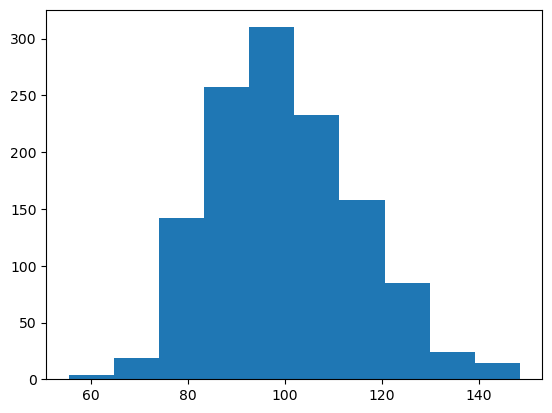

In [6]:
fig = plt.figure()
plt.hist(dataset.data.y * bhq_std + bhq_mean)

In [7]:
with open("param.yaml") as f:
    tmp = yaml.safe_load(f)  # config is dict
    prm_set = AttrDict(tmp)
prm_set1 = prm_set.param_set1
prm_set2 = prm_set.param_set2
prm_set3 = prm_set.param_set3
prm_set4 = prm_set.param_set4

In [38]:
def cross_val(dataset_all, param_dict, exp_name, save_model = True):
    seed_everything(seed = 42)
    print(f"parameters : {param_dict}")
    # setting parameters
    n_epochs, n_splits, lr_init, weight_decay, patience, ratio, k, lambda_p, lambda_tpk, batch_size = param_dict.values()
    lr_init = float(lr_init)
    weight_decay = float(weight_decay)
    kf = KFold(n_splits = n_splits, shuffle = False)
    
    # check dir for logging
    save_dir = osp.join("../log", exp_name)
    if not osp.exists(save_dir):
        os.makedirs(save_dir)
    
    # logs
    loss_best_fold = 1e10
    mae_list = []
    predictions = []
    results = dict()
    # outer loop
    for n_fold_outer ,(train_idx_outer, test_idx) in enumerate(kf.split(dataset_all)):
        print(f"===================== This is fold #{n_fold_outer + 1} / {n_splits}. =====================")
        exp_dir = osp.join(save_dir, "fold_" + str(n_fold_outer + 1))
        if not os.path.exists(exp_dir):
            os.mkdir(exp_dir)
        # dividing all data into train and test
        train_dataset_outer = dataset_all[train_idx_outer]
        test_dataset = dataset_all[test_idx]
        # inner loop
        for n_fold_inner, (train_idx_inner, val_idx) in enumerate(kf.split(train_dataset_outer)):
            # dividing train data into train_inner and validation
            print(f"-----------------------This is inner fold {n_fold_inner + 1} / {n_splits}-----------------------")
            train_dataset_inner = train_dataset_outer[train_idx_inner]
            val_dataset = train_dataset_outer[val_idx]
            train_loader = DataListLoader(train_dataset_inner, batch_size = batch_size, shuffle = False)
            val_loader = DataListLoader(val_dataset, batch_size = batch_size, shuffle = False)
            train_loss_list = []
            val_loss_list = []
            val_pred = []
            model = Network3layers(indim = 116, ratio = ratio, k = k, nclass = 1, R = 116).to(device)
            if torch.cuda.device_count() > 1:
                # print(f"Let's use {torch.cuda.device_count()} GPUs!!")
                model = DP(model)
            optimizer = optim.AdamW(model.parameters(), lr = lr_init, weight_decay = weight_decay) # Adam -> AdamW
            scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20, eta_min = 1e-4) # <= added
            best_loss = 1e10
            best_epoch = None
            # early stopping
            es = EarlyStopping(patience = patience, verbose = 1, mode = "loss")
            stopped_epoch = n_epochs
            for epoch in range(n_epochs):
                # training phase with train dataset
                model.train()
                train_loss_all = .0
                for data_list in train_loader:
                    optimizer.zero_grad()
                    output, train_loss = train_step(data_list, model, optimizer, ratio = ratio, lambda_p = lambda_p, lambda_tpk = lambda_tpk)
                    scheduler.step()
                    train_loss_all += train_loss.item() * len(data_list)
                train_loss_all = train_loss_all / len(train_loader.dataset)
                # evaluating phase with validation dataset
                model.eval()
                with torch.no_grad():
                    val_loss_all = .0
                    for data_list in val_loader:
                        output, val_loss = val_step(data_list, model, ratio =  ratio, lambda_p = lambda_p, lambda_tpk = lambda_tpk)
                        val_loss_all += val_loss.item() * len(data_list)
                    val_loss_all = val_loss_all / len(val_loader.dataset)
                if epoch == 0 or  (epoch + 1) % (n_epochs // 5) == 0:
                    print(f"Epoch : [{epoch + 1} / {n_epochs}] || Train Loss : {train_loss_all} | Validation Loss : {val_loss_all}")
                train_loss_list.append(train_loss_all)
                val_loss_list.append(val_loss_all)
                if val_loss_all < best_loss and (epoch + 1) > 5:
                    best_epoch = epoch + 1
                    best_loss = val_loss_all
                    best_model_wts = copy.deepcopy(model.state_dict())
                    if save_model:
                        model_path = osp.join(exp_dir, "model_weights.pth")
                        torch.save(best_model_wts, model_path)
                # early stopping
                if epoch <= 50:
                    pass
                elif es(val_loss_all):
                    stopped_epoch = epoch + 1
                    print(f"Training phase stopped in epoch#{stopped_epoch}.")
                    break
            # *********************** all epochs done here ***********************
            print(f"fold {n_fold_inner} is done!!")
            print(f"best epoch is #{best_epoch}. validation loss : {best_loss}")
            # plotting loss curve
            plot_loss_curve(
                train_loss_list=train_loss_list,
                test_loss_list=val_loss_list,
                stopped_epoch=stopped_epoch,
                n_fold=n_fold_inner,
                save_fig=True,
                save_path=exp_dir,
                )
        # predicting with best model for vizualizing results
        model.load_state_dict(torch.load(model_path))
        test_loader = DataListLoader(test_dataset, batch_size = batch_size, shuffle = False)
        with torch.no_grad():
            test_pred = []
            for data_list in test_loader:
                output, test_loss = test_step(data_list, model, ratio = ratio, lambda_p = lambda_p, lambda_tpk = lambda_tpk)
                test_pred.append(output["pred"])
        test_label = test_loader.dataset.data.y[test_idx].numpy()
        test_pred = torch.cat(test_pred).to("cpu").detach().numpy().copy().squeeze()
        predictions.append(test_pred)
        mae = MAE(test_label, test_pred) * bhq_std
        mae_list.append(mae)
        if mae < loss_best_fold:
            best_fold = n_fold_outer + 1
            loss_best_fold = mae
        
        # freeing memory
        del(model, train_dataset_outer, train_dataset_inner, val_dataset, train_loader, test_dataset, test_loader, test_pred, test_label)
        gc.collect()
        torch.cuda.empty_cache()
    print(f"best fold is {best_fold}. MAE = {loss_best_fold}.")
    print(f"Mean MAE = {np.mean(mae_list)} / std = {np.std(mae_list)}.")
    predictions = np.concatenate(predictions)
    np.save(osp.join(save_dir, "predictions.npy"), predictions)
    results["params"] = param_dict
    results["mae"] = mae_list
    results["best_fold"] = best_fold
    results_path = osp.join(save_dir, "results.pkl")
    with open(results_path,"wb") as f:
        pickle.dump(results, f)

parameters : AttrDict({'n_epochs': 100, 'n_splits': 5, 'lr_init': '1e-3', 'weight_decay': '5e-3', 'patience': 10, 'ratio': 0.5, 'k': 7, 'lambda_p': 0.1, 'lambda_tpk': 0.1, 'batch_size': 32})
===================== This is fold #1 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5928023280809873 | Validation Loss : 1.5173910140991211
Epoch : [20 / 100] || Train Loss : 1.0699404609862284 | Validation Loss : 1.148033208847046
Epoch : [40 / 100] || Train Loss : 0.882975002629074 | Validation Loss : 1.156393756866455
Epoch : [60 / 100] || Train Loss : 0.7979061238130732 | Validation Loss : 1.1900040435791015
early stopping
Training phase stopped in epoch#65.
fold 0 is done!!
best epoch is #25. validation loss : 1.113214693069458


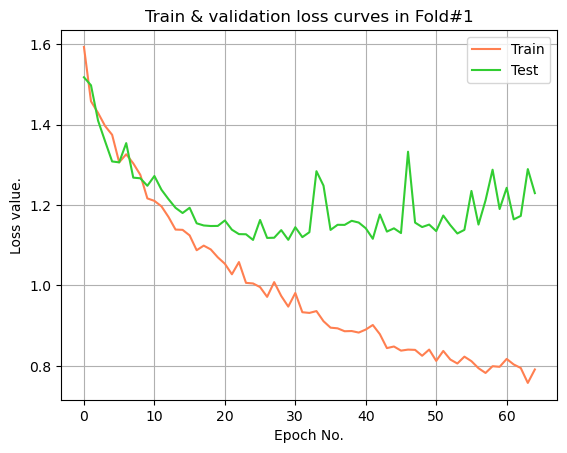

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6452026443469479 | Validation Loss : 1.6183768816329727
Epoch : [20 / 100] || Train Loss : 1.0436046110043113 | Validation Loss : 1.2219558397130152
Epoch : [40 / 100] || Train Loss : 0.8749624864669188 | Validation Loss : 1.2457631670649927
Epoch : [60 / 100] || Train Loss : 0.8189033430672649 | Validation Loss : 1.2255661391732682
early stopping
Training phase stopped in epoch#66.
fold 1 is done!!
best epoch is #32. validation loss : 1.1540011748596652


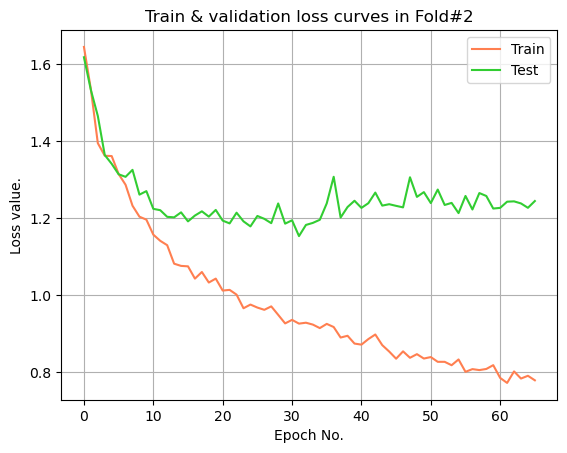

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5575070403600426 | Validation Loss : 1.289241695523861
Epoch : [20 / 100] || Train Loss : 1.0934997994448041 | Validation Loss : 0.9751485993514708
Epoch : [40 / 100] || Train Loss : 0.9346012541161876 | Validation Loss : 1.007875140587888
Epoch : [60 / 100] || Train Loss : 0.8423463040343492 | Validation Loss : 1.032214392369716
early stopping
Training phase stopped in epoch#63.
fold 2 is done!!
best epoch is #25. validation loss : 0.9453589862315499


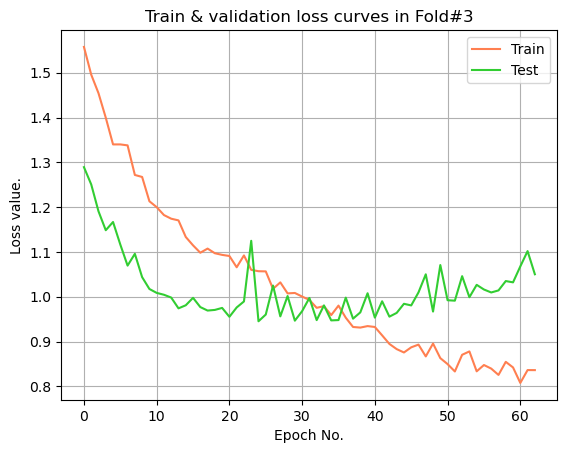

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5711034738284582 | Validation Loss : 1.592367531067163
Epoch : [20 / 100] || Train Loss : 1.0841880884942325 | Validation Loss : 1.1702046538118143
Epoch : [40 / 100] || Train Loss : 0.8867709276218486 | Validation Loss : 1.2335377727920687
Epoch : [60 / 100] || Train Loss : 0.8025236092367615 | Validation Loss : 1.2233940800230707
early stopping
Training phase stopped in epoch#68.
fold 3 is done!!
best epoch is #29. validation loss : 1.1261590485596777


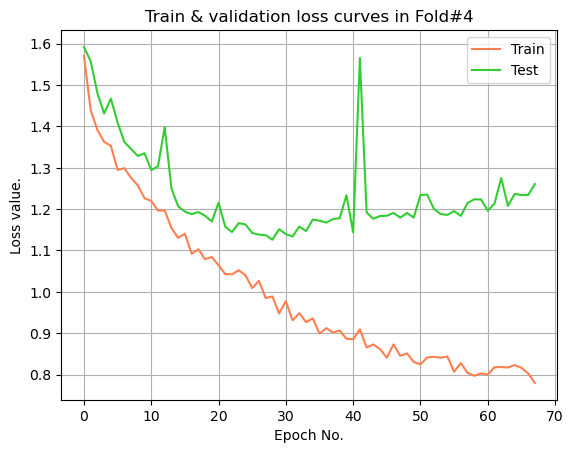

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6459659837569616 | Validation Loss : 1.352014394261729
Epoch : [20 / 100] || Train Loss : 1.0553917835467732 | Validation Loss : 1.177556907112275
Epoch : [40 / 100] || Train Loss : 0.8693998215937405 | Validation Loss : 1.1644585869420114
Epoch : [60 / 100] || Train Loss : 0.8170034711902384 | Validation Loss : 1.1221795555335194
early stopping
Training phase stopped in epoch#71.
fold 4 is done!!
best epoch is #60. validation loss : 1.1221795555335194


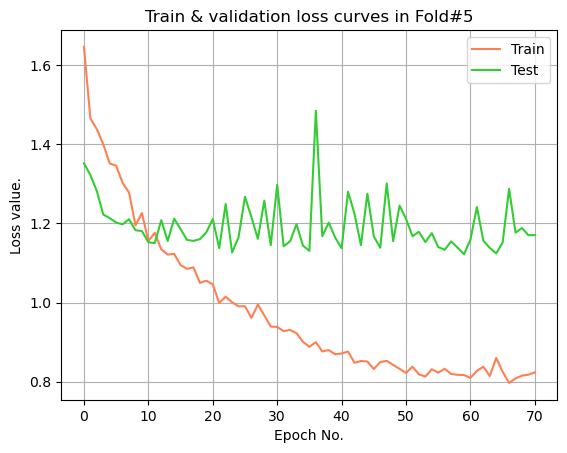

Saved fig.
===================== This is fold #2 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4986915049917875 | Validation Loss : 1.444370141029358
Epoch : [20 / 100] || Train Loss : 1.019121637009318 | Validation Loss : 1.1527980971336365
Epoch : [40 / 100] || Train Loss : 0.8232907688004459 | Validation Loss : 1.157703824043274
Epoch : [60 / 100] || Train Loss : 0.7805482588867322 | Validation Loss : 1.1541484189033508
early stopping
Training phase stopped in epoch#68.
fold 0 is done!!
best epoch is #26. validation loss : 1.1252535104751586


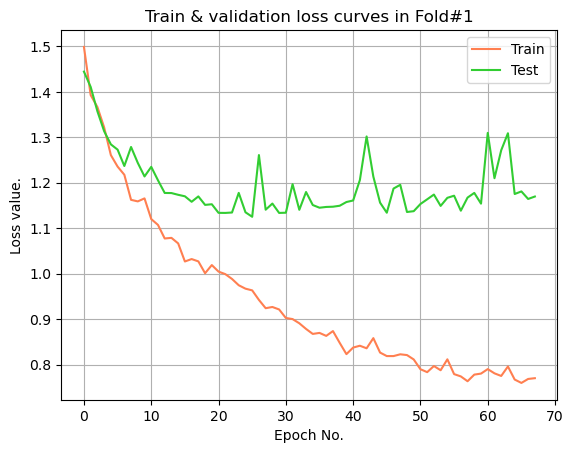

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.7293298232510517 | Validation Loss : 1.427040376663208
Epoch : [20 / 100] || Train Loss : 1.0676532609848635 | Validation Loss : 1.1868065738677978
Epoch : [40 / 100] || Train Loss : 0.8458278611433252 | Validation Loss : 1.1635926246643067
Epoch : [60 / 100] || Train Loss : 0.7667242934742716 | Validation Loss : 1.1958834743499756
early stopping
Training phase stopped in epoch#65.
fold 1 is done!!
best epoch is #33. validation loss : 1.1046933603286744


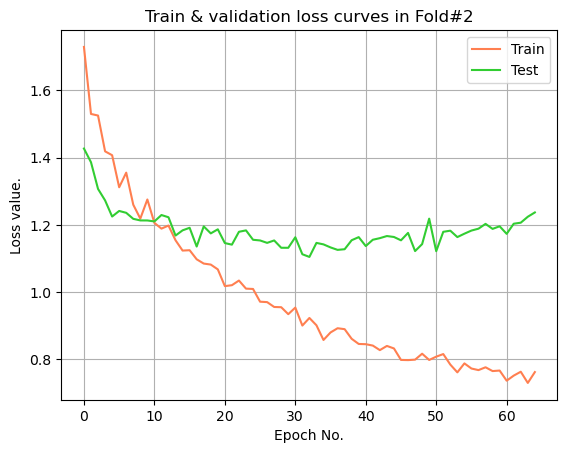

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.576749192742178 | Validation Loss : 1.2856566082293064
Epoch : [20 / 100] || Train Loss : 1.055108956824568 | Validation Loss : 0.9849940436569291
Epoch : [40 / 100] || Train Loss : 0.8998893868355524 | Validation Loss : 0.9785182937305776
Epoch : [60 / 100] || Train Loss : 0.8225725990787783 | Validation Loss : 0.9902918266890636
early stopping
Training phase stopped in epoch#72.
fold 2 is done!!
best epoch is #34. validation loss : 0.9682182828385626


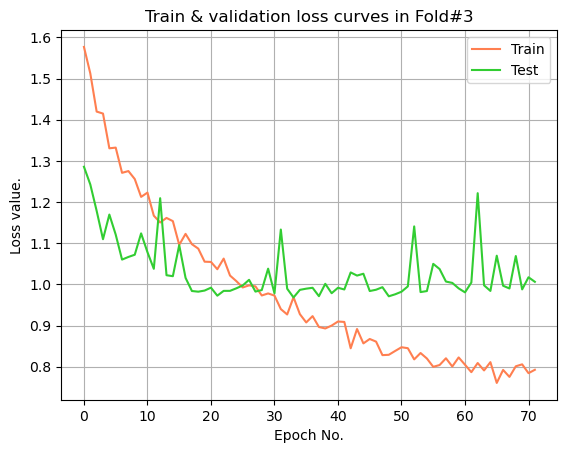

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5905670172588569 | Validation Loss : 1.6108498980651549
Epoch : [20 / 100] || Train Loss : 0.996053323411105 | Validation Loss : 1.1650511047348904
Epoch : [40 / 100] || Train Loss : 0.8751395906422073 | Validation Loss : 1.1514137486117568
Epoch : [60 / 100] || Train Loss : 0.8116877808009174 | Validation Loss : 1.117711541041657
early stopping
Training phase stopped in epoch#71.
fold 3 is done!!
best epoch is #60. validation loss : 1.117711541041657


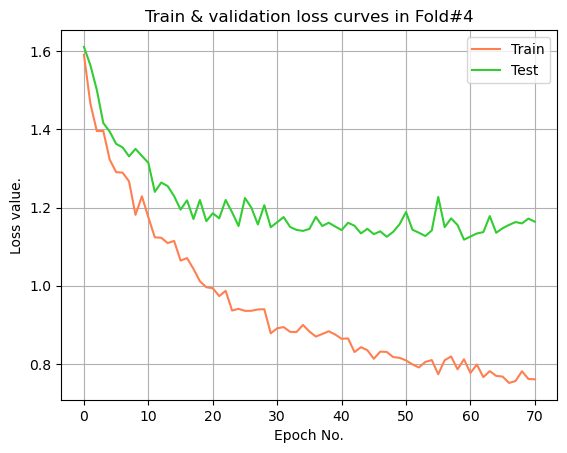

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5882786563165803 | Validation Loss : 1.29192064395502
Epoch : [20 / 100] || Train Loss : 1.007192091386121 | Validation Loss : 1.1166793587219774
Epoch : [40 / 100] || Train Loss : 0.828171486095677 | Validation Loss : 1.1655320558116664
Epoch : [60 / 100] || Train Loss : 0.7698063309628862 | Validation Loss : 1.2501242382442532
early stopping
Training phase stopped in epoch#66.
fold 4 is done!!
best epoch is #50. validation loss : 1.1071934867743871


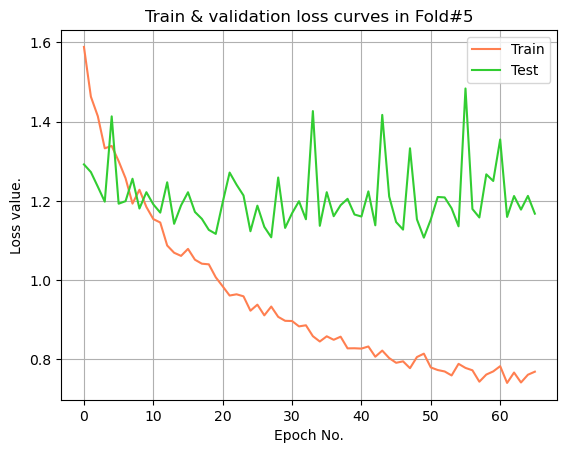

Saved fig.
===================== This is fold #3 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6525748963637215 | Validation Loss : 1.4421338367462158
Epoch : [20 / 100] || Train Loss : 1.0463829879629118 | Validation Loss : 1.152481164932251
Epoch : [40 / 100] || Train Loss : 0.9112976611483202 | Validation Loss : 1.101826581954956
Epoch : [60 / 100] || Train Loss : 0.8302492885996436 | Validation Loss : 1.148215742111206
early stopping
Training phase stopped in epoch#65.
fold 0 is done!!
best epoch is #54. validation loss : 1.092814416885376


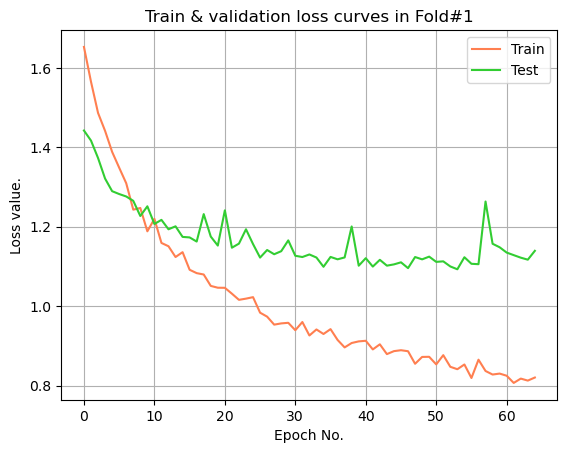

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.7524178446909715 | Validation Loss : 1.3688598990440368
Epoch : [20 / 100] || Train Loss : 1.1296805360236462 | Validation Loss : 1.0051201033592223
Epoch : [40 / 100] || Train Loss : 0.8793678578349249 | Validation Loss : 1.07158438205719
Epoch : [60 / 100] || Train Loss : 0.790704125293076 | Validation Loss : 1.2254287338256835
early stopping
Training phase stopped in epoch#63.
fold 1 is done!!
best epoch is #24. validation loss : 0.9876255226135254


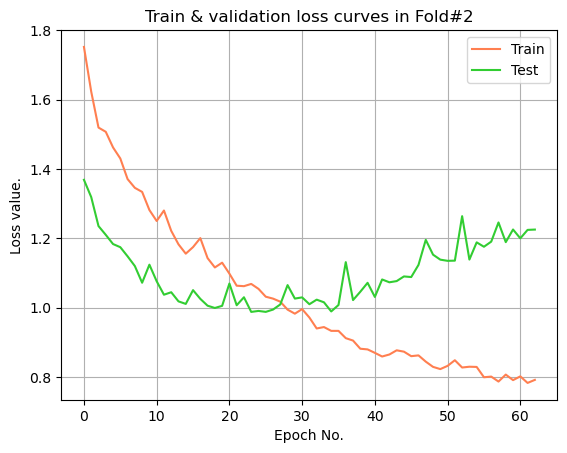

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.528139414942653 | Validation Loss : 1.623228184841386
Epoch : [20 / 100] || Train Loss : 1.0656117726686902 | Validation Loss : 1.1993823189232218
Epoch : [40 / 100] || Train Loss : 0.8717127865119686 | Validation Loss : 1.154013219790243
Epoch : [60 / 100] || Train Loss : 0.7981893905720914 | Validation Loss : 1.1524931312206403
early stopping
Training phase stopped in epoch#68.
fold 2 is done!!
best epoch is #41. validation loss : 1.1064830539214552


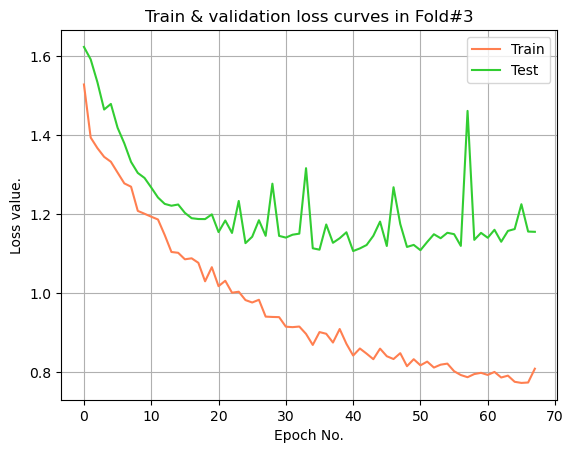

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.599958752629751 | Validation Loss : 1.6241561431980611
Epoch : [20 / 100] || Train Loss : 0.9576215346654257 | Validation Loss : 1.3240077920894526
Epoch : [40 / 100] || Train Loss : 0.8309758354846696 | Validation Loss : 1.2412100137777664
Epoch : [60 / 100] || Train Loss : 0.7483150103038415 | Validation Loss : 1.2268144227751536
early stopping
Training phase stopped in epoch#73.
fold 3 is done!!
best epoch is #62. validation loss : 1.1961272415803306


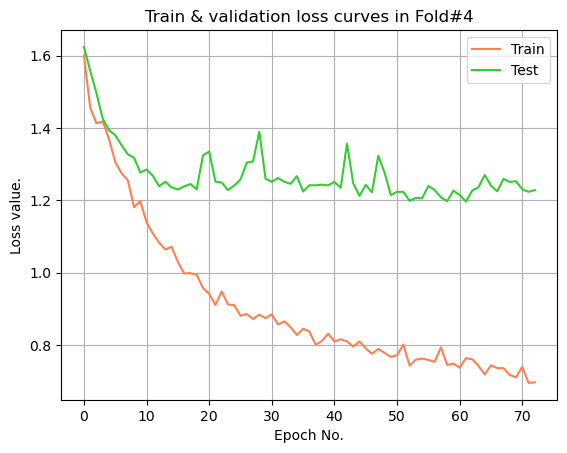

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6432716888293886 | Validation Loss : 1.319116483381645
Epoch : [20 / 100] || Train Loss : 1.0484565218588464 | Validation Loss : 1.1126505885291937
Epoch : [40 / 100] || Train Loss : 0.8769961882354622 | Validation Loss : 1.2922311380280922
Epoch : [60 / 100] || Train Loss : 0.8032401184689132 | Validation Loss : 1.2201817532879624
early stopping
Training phase stopped in epoch#75.
fold 4 is done!!
best epoch is #36. validation loss : 1.0609643375454236


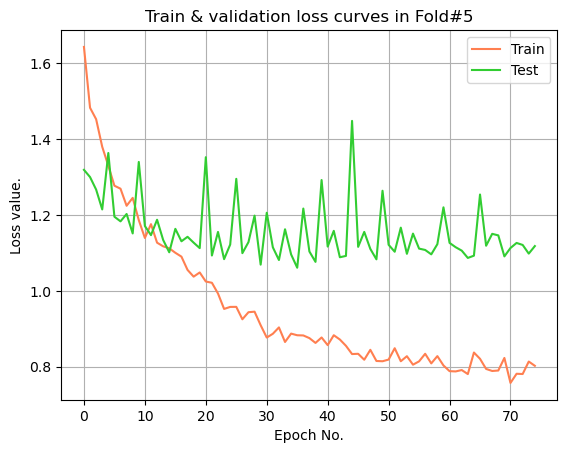

Saved fig.
===================== This is fold #4 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5926758969293784 | Validation Loss : 1.4348114252090454
Epoch : [20 / 100] || Train Loss : 1.0798764468136814 | Validation Loss : 1.1935649371147157
Epoch : [40 / 100] || Train Loss : 0.9108092626334733 | Validation Loss : 1.148381109237671
Epoch : [60 / 100] || Train Loss : 0.8535238250136525 | Validation Loss : 1.096391773223877
early stopping
Training phase stopped in epoch#66.
fold 0 is done!!
best epoch is #55. validation loss : 1.0757015991210936


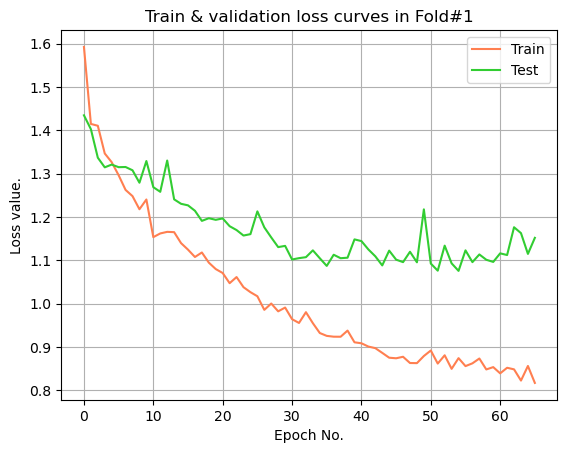

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.73139856062091 | Validation Loss : 1.3297026920318604
Epoch : [20 / 100] || Train Loss : 1.1074816248796815 | Validation Loss : 1.001947011947632
Epoch : [40 / 100] || Train Loss : 0.8434861116905883 | Validation Loss : 1.0487628030776976
Epoch : [60 / 100] || Train Loss : 0.775187155084598 | Validation Loss : 1.128359580039978
early stopping
Training phase stopped in epoch#69.
fold 1 is done!!
best epoch is #24. validation loss : 0.9841505002975464


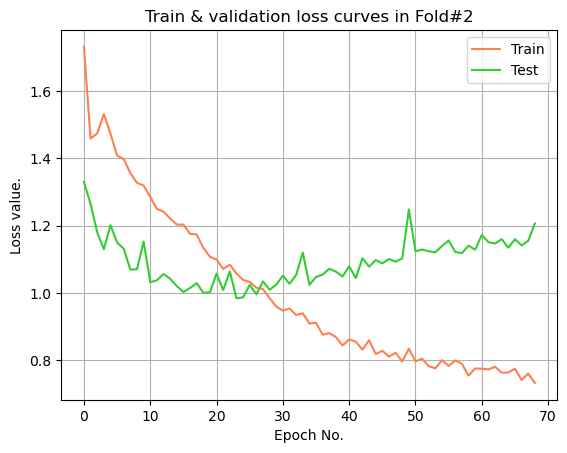

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.700796703945724 | Validation Loss : 1.568485564322927
Epoch : [20 / 100] || Train Loss : 1.0409762919098513 | Validation Loss : 1.1599186389290508
Epoch : [40 / 100] || Train Loss : 0.8510951900243161 | Validation Loss : 1.105727302369161
Epoch : [60 / 100] || Train Loss : 0.7420981500979354 | Validation Loss : 1.1108741215126
early stopping
Training phase stopped in epoch#67.
fold 2 is done!!
best epoch is #38. validation loss : 1.077723452793294


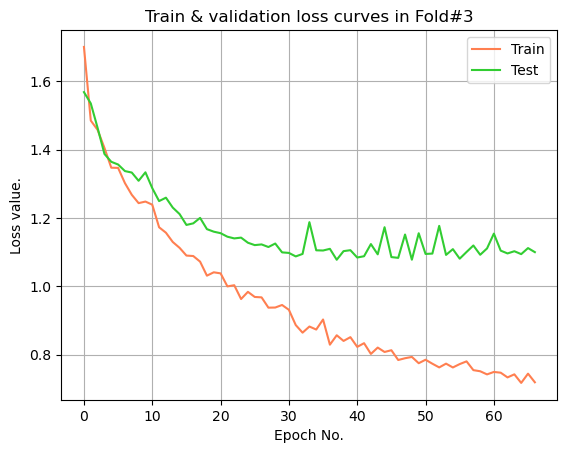

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6633770391158293 | Validation Loss : 1.4411224426336624
Epoch : [20 / 100] || Train Loss : 1.1126502121899062 | Validation Loss : 1.1112606210924274
Epoch : [40 / 100] || Train Loss : 0.8935071235910096 | Validation Loss : 1.087635752843253
Epoch : [60 / 100] || Train Loss : 0.7920690904882618 | Validation Loss : 1.1031223463652722
early stopping
Training phase stopped in epoch#68.
fold 3 is done!!
best epoch is #30. validation loss : 1.0736287619600344


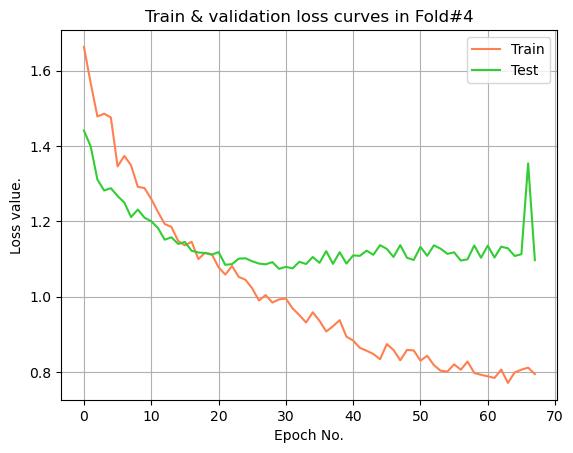

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.650808040360759 | Validation Loss : 1.3864225951870481
Epoch : [20 / 100] || Train Loss : 1.072494317863818 | Validation Loss : 1.1070790943787925
Epoch : [40 / 100] || Train Loss : 0.8403452058185014 | Validation Loss : 1.1082221790773785
Epoch : [60 / 100] || Train Loss : 0.7640203823123062 | Validation Loss : 1.1538794519913256
early stopping
Training phase stopped in epoch#66.
fold 4 is done!!
best epoch is #21. validation loss : 1.0878485087773309


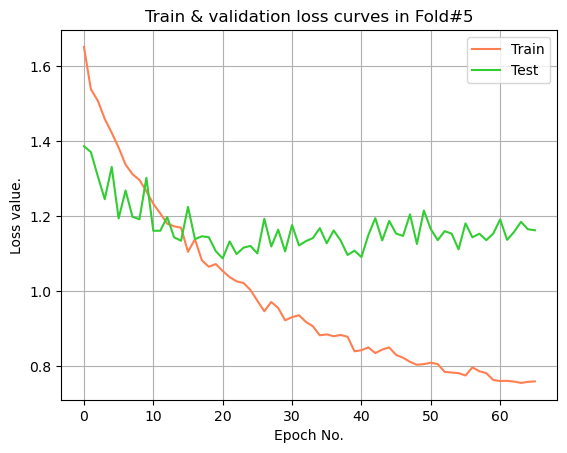

Saved fig.
===================== This is fold #5 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6464567698977672 | Validation Loss : 1.4607721328735352
Epoch : [20 / 100] || Train Loss : 1.0483628386535788 | Validation Loss : 1.129091649055481
Epoch : [40 / 100] || Train Loss : 0.843655019587226 | Validation Loss : 1.1445934534072877
Epoch : [60 / 100] || Train Loss : 0.7801094301222559 | Validation Loss : 1.102330389022827
early stopping
Training phase stopped in epoch#66.
fold 0 is done!!
best epoch is #28. validation loss : 1.0821242618560791


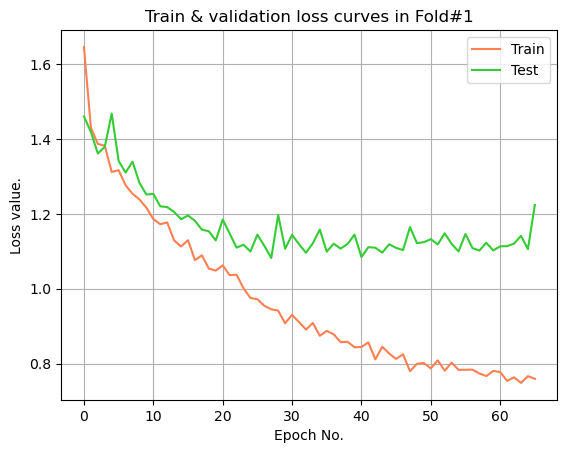

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5420517631277086 | Validation Loss : 1.3574084281921386
Epoch : [20 / 100] || Train Loss : 1.037361899538052 | Validation Loss : 1.0135151863098144
Epoch : [40 / 100] || Train Loss : 0.8644515751595778 | Validation Loss : 1.0099022245407105
Epoch : [60 / 100] || Train Loss : 0.7997977247501407 | Validation Loss : 1.0935384702682496
early stopping
Training phase stopped in epoch#69.
fold 1 is done!!
best epoch is #46. validation loss : 0.9879858303070068


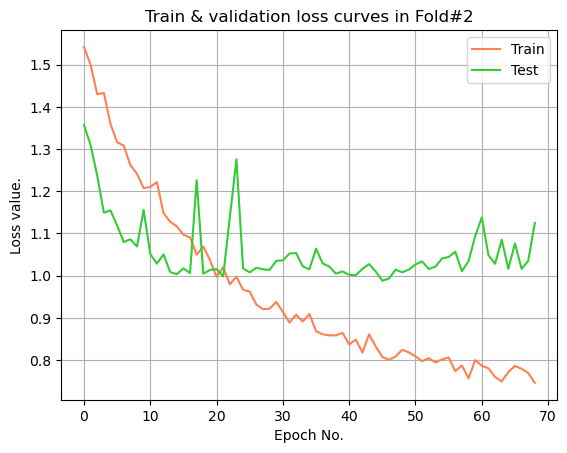

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5360951008354513 | Validation Loss : 1.56508093742869
Epoch : [20 / 100] || Train Loss : 1.0082262177813919 | Validation Loss : 1.2399840109312354
Epoch : [40 / 100] || Train Loss : 0.8115008343431286 | Validation Loss : 1.2185683561928908
Epoch : [60 / 100] || Train Loss : 0.7269085012282943 | Validation Loss : 1.1510015576329065
early stopping
Training phase stopped in epoch#76.
fold 2 is done!!
best epoch is #65. validation loss : 1.1234134303864522


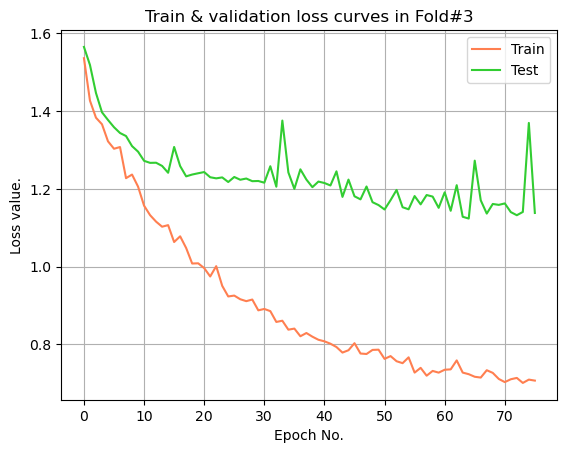

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6104796076179446 | Validation Loss : 1.3769417833443263
Epoch : [20 / 100] || Train Loss : 1.0673203995652067 | Validation Loss : 1.130114817739132
Epoch : [40 / 100] || Train Loss : 0.862969322013377 | Validation Loss : 1.1192719058774823
Epoch : [60 / 100] || Train Loss : 0.7613958248817233 | Validation Loss : 1.154405737342547
Epoch : [80 / 100] || Train Loss : 0.7185468433196085 | Validation Loss : 1.2097872567536243
early stopping
Training phase stopped in epoch#95.
fold 3 is done!!
best epoch is #42. validation loss : 1.095291892487799


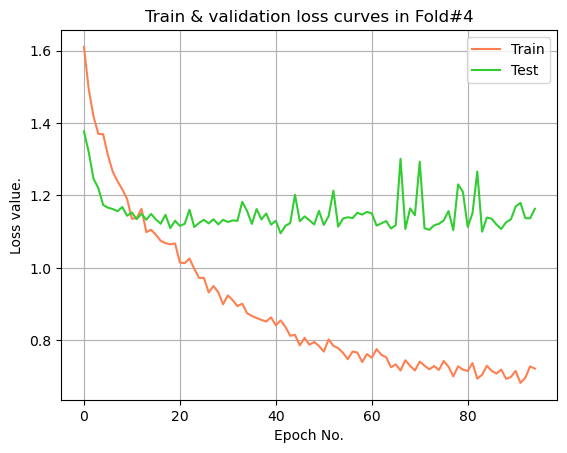

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6381401513752185 | Validation Loss : 1.5489705411633055
Epoch : [20 / 100] || Train Loss : 1.0464473141165902 | Validation Loss : 1.1103246529497692
Epoch : [40 / 100] || Train Loss : 0.8556297518555682 | Validation Loss : 1.1294381564586007
Epoch : [60 / 100] || Train Loss : 0.7851317230621376 | Validation Loss : 1.2068590638625563
early stopping
Training phase stopped in epoch#70.
fold 4 is done!!
best epoch is #28. validation loss : 1.0851931182583372


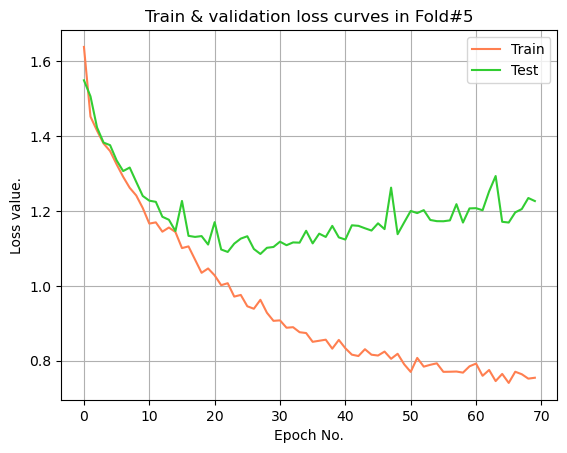

Saved fig.
best fold is 2. MAE = 9.287970850857718.
Mean MAE = 9.548576058451925 / std = 0.13605127850302107.


In [39]:
cross_val(dataset, param_dict = prm_set1, exp_name = "model1")

parameters : AttrDict({'n_epochs': 100, 'n_splits': 5, 'lr_init': '1e-3', 'weight_decay': '5e-3', 'patience': 10, 'ratio': 0.5, 'k': 8, 'lambda_p': 0.1, 'lambda_tpk': 0.1, 'batch_size': 32})
===================== This is fold #1 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.657464833714854 | Validation Loss : 1.5603967380523682
Epoch : [20 / 100] || Train Loss : 1.031265472047892 | Validation Loss : 1.247725110054016
Epoch : [40 / 100] || Train Loss : 0.8478765562551105 | Validation Loss : 1.1024352264404298
Epoch : [60 / 100] || Train Loss : 0.7728849313965994 | Validation Loss : 1.1348756313323975
early stopping
Training phase stopped in epoch#68.
fold 0 is done!!
best epoch is #57. validation loss : 1.0789693260192872


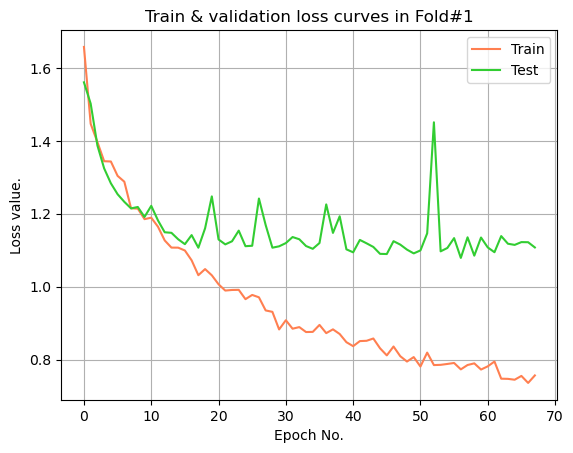

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5822986159450287 | Validation Loss : 1.726135929625238
Epoch : [20 / 100] || Train Loss : 1.072220905213015 | Validation Loss : 1.1678270167441824
Epoch : [40 / 100] || Train Loss : 0.8997794077118187 | Validation Loss : 1.0969196563989074
Epoch : [60 / 100] || Train Loss : 0.8241722760266312 | Validation Loss : 1.1284853753133035
early stopping
Training phase stopped in epoch#74.
fold 1 is done!!
best epoch is #63. validation loss : 1.0868512865286977


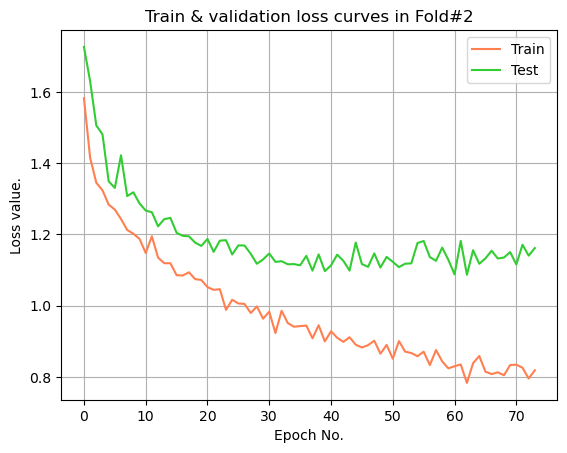

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.774418072239817 | Validation Loss : 1.3031956954817077
Epoch : [20 / 100] || Train Loss : 1.1249788214301824 | Validation Loss : 1.0056225828189946
Epoch : [40 / 100] || Train Loss : 0.8959132881655149 | Validation Loss : 1.0001324211532747
Epoch : [60 / 100] || Train Loss : 0.811859597076885 | Validation Loss : 1.045147039482941
early stopping
Training phase stopped in epoch#79.
fold 2 is done!!
best epoch is #38. validation loss : 0.9849034188380793


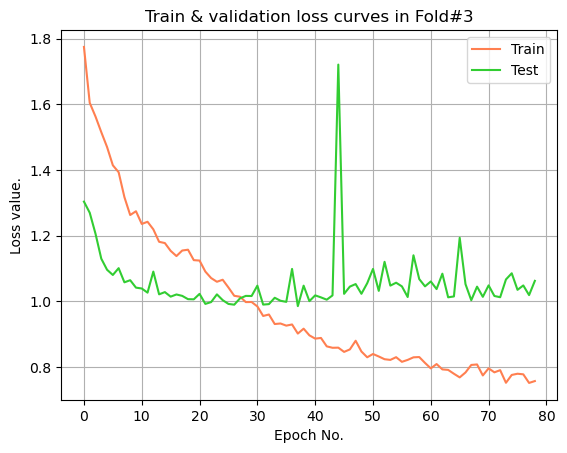

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5629237861824754 | Validation Loss : 1.6006542165674755
Epoch : [20 / 100] || Train Loss : 1.0620650718621956 | Validation Loss : 1.2683126465160044
Epoch : [40 / 100] || Train Loss : 0.8529014642744172 | Validation Loss : 1.2564055110940981
Epoch : [60 / 100] || Train Loss : 0.7706021421975743 | Validation Loss : 1.2780369735842374
early stopping
Training phase stopped in epoch#66.
fold 3 is done!!
best epoch is #44. validation loss : 1.217323925027895


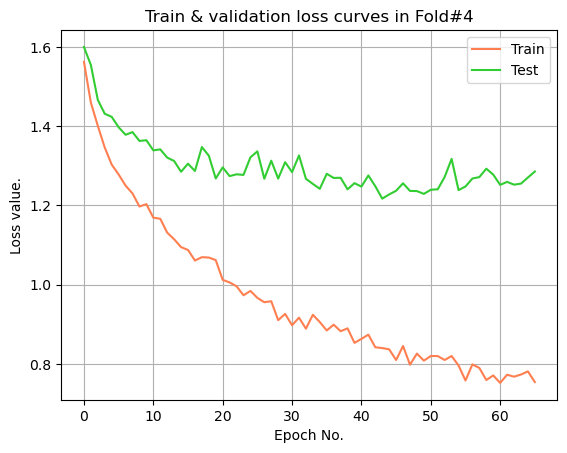

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.676489404483302 | Validation Loss : 1.3135915617247922
Epoch : [20 / 100] || Train Loss : 1.0894279782116936 | Validation Loss : 1.1450847225572596
Epoch : [40 / 100] || Train Loss : 0.8807978115536488 | Validation Loss : 1.136489287093656
Epoch : [60 / 100] || Train Loss : 0.799047801844598 | Validation Loss : 1.1485379065700512
early stopping
Training phase stopped in epoch#65.
fold 4 is done!!
best epoch is #41. validation loss : 1.060507205263454


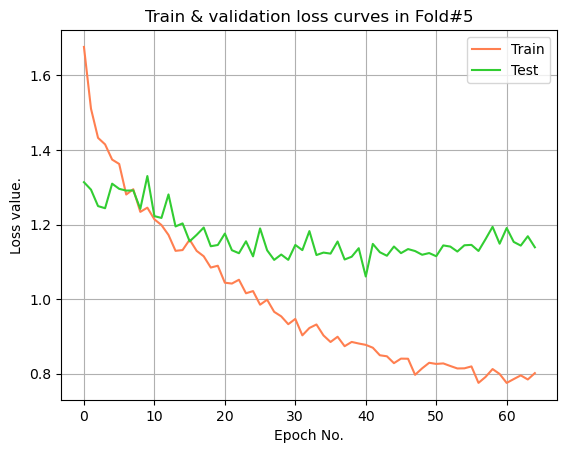

Saved fig.
===================== This is fold #2 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.479425096452012 | Validation Loss : 1.4462204885482788
Epoch : [20 / 100] || Train Loss : 1.074559459198673 | Validation Loss : 1.1303726196289063
Epoch : [40 / 100] || Train Loss : 0.8709625554653153 | Validation Loss : 1.13366934299469
Epoch : [60 / 100] || Train Loss : 0.7938364111494689 | Validation Loss : 1.16042977809906
early stopping
Training phase stopped in epoch#63.
fold 0 is done!!
best epoch is #38. validation loss : 1.0824216651916503


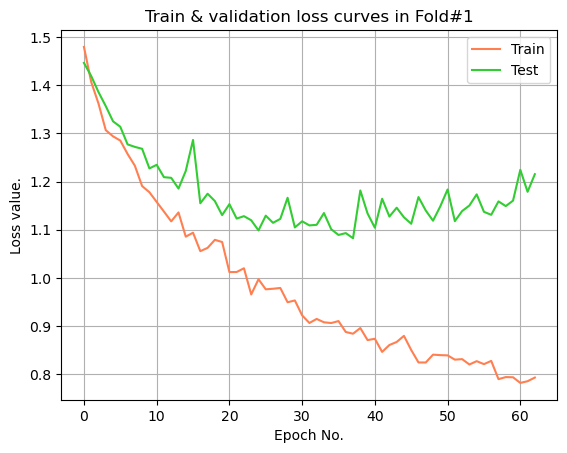

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4725883778843707 | Validation Loss : 1.3777154445648194
Epoch : [20 / 100] || Train Loss : 1.0447176107050036 | Validation Loss : 1.074830355644226
Epoch : [40 / 100] || Train Loss : 0.7990536564117393 | Validation Loss : 1.0478899812698363
Epoch : [60 / 100] || Train Loss : 0.7698549061377943 | Validation Loss : 1.068728814125061
Epoch : [80 / 100] || Train Loss : 0.732470558608042 | Validation Loss : 1.1059098625183106
early stopping
Training phase stopped in epoch#80.
fold 1 is done!!
best epoch is #32. validation loss : 1.0244048023223877


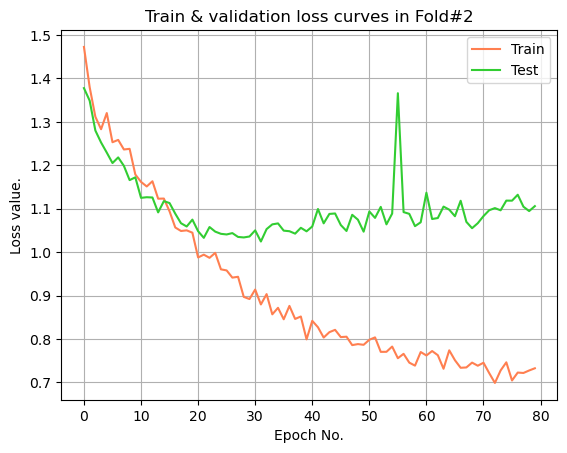

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6297624965658164 | Validation Loss : 1.2799669114788572
Epoch : [20 / 100] || Train Loss : 1.0745004113754235 | Validation Loss : 1.015535052996784
Epoch : [40 / 100] || Train Loss : 0.8849635173503617 | Validation Loss : 1.0746193956490138
Epoch : [60 / 100] || Train Loss : 0.7896387299200646 | Validation Loss : 1.1508176928788574
early stopping
Training phase stopped in epoch#74.
fold 2 is done!!
best epoch is #24. validation loss : 1.0064627555147487


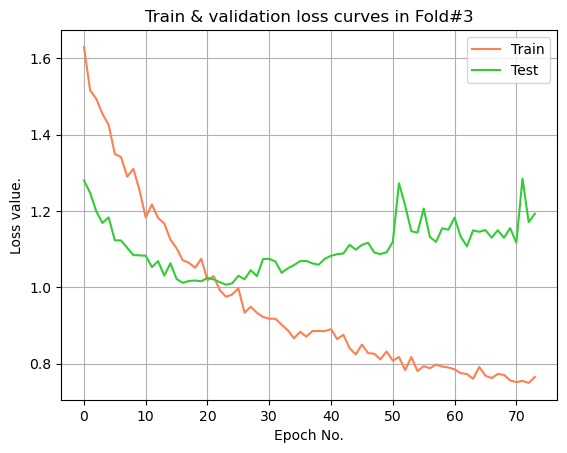

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.619627773612364 | Validation Loss : 1.603368775628919
Epoch : [20 / 100] || Train Loss : 0.997489241131565 | Validation Loss : 1.1283327964083034
Epoch : [40 / 100] || Train Loss : 0.7969328850731814 | Validation Loss : 1.1632297596140722
Epoch : [60 / 100] || Train Loss : 0.7400652358406469 | Validation Loss : 1.1433967235100329
early stopping
Training phase stopped in epoch#65.
fold 3 is done!!
best epoch is #54. validation loss : 1.1161450159609618


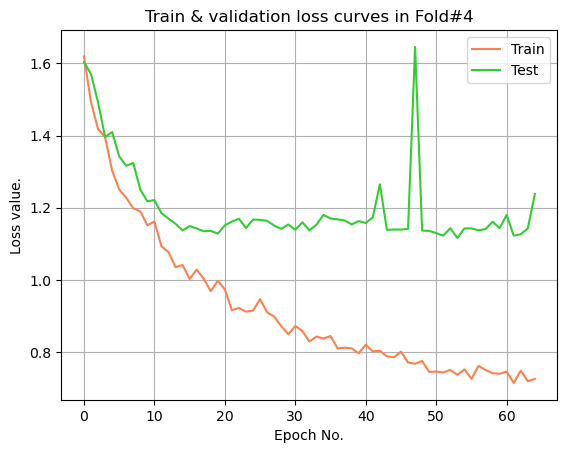

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5011595012550067 | Validation Loss : 1.3356669308552191
Epoch : [20 / 100] || Train Loss : 1.0089393734633176 | Validation Loss : 1.0959537760097178
Epoch : [40 / 100] || Train Loss : 0.8457915570801661 | Validation Loss : 1.1255491690420025
Epoch : [60 / 100] || Train Loss : 0.751241523819161 | Validation Loss : 1.1419026635999057
early stopping
Training phase stopped in epoch#68.
fold 4 is done!!
best epoch is #27. validation loss : 1.059817607079319


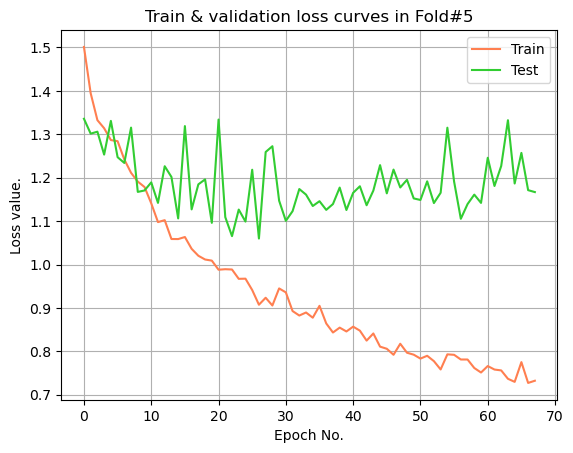

Saved fig.
===================== This is fold #3 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6600367451551716 | Validation Loss : 1.4381857347488403
Epoch : [20 / 100] || Train Loss : 1.0338280719974857 | Validation Loss : 1.105438964366913
Epoch : [40 / 100] || Train Loss : 0.8240989875913115 | Validation Loss : 1.1134042835235596
Epoch : [60 / 100] || Train Loss : 0.7574317084351926 | Validation Loss : 1.1861477279663086
early stopping
Training phase stopped in epoch#63.
fold 0 is done!!
best epoch is #27. validation loss : 1.072233738899231


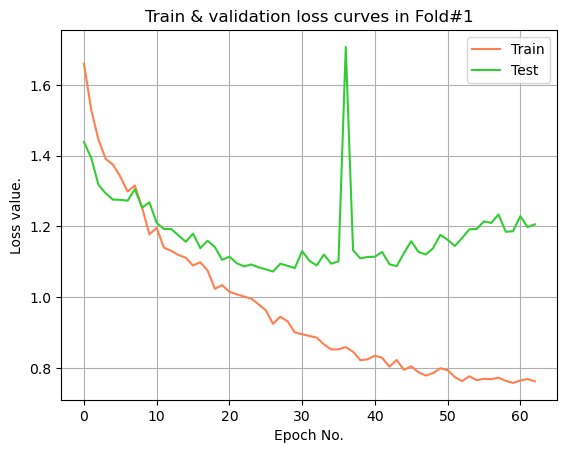

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6756726436064564 | Validation Loss : 1.3193513441085816
Epoch : [20 / 100] || Train Loss : 1.0442304696462386 | Validation Loss : 0.9447834205627441
Epoch : [40 / 100] || Train Loss : 0.9051761724419396 | Validation Loss : 1.776561689376831
Epoch : [60 / 100] || Train Loss : 0.8816537419556075 | Validation Loss : 1.1597807598114014
early stopping
Training phase stopped in epoch#65.
fold 1 is done!!
best epoch is #20. validation loss : 0.9447834205627441


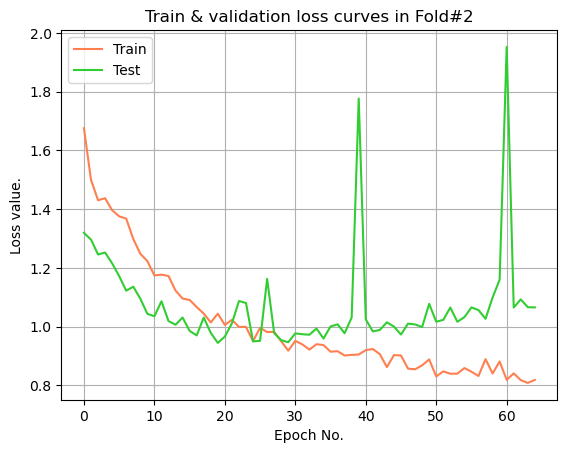

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5633876568691474 | Validation Loss : 1.5772614592882856
Epoch : [20 / 100] || Train Loss : 1.0299334543988221 | Validation Loss : 1.1610431428530708
Epoch : [40 / 100] || Train Loss : 0.8632777095737314 | Validation Loss : 1.0865174022751238
Epoch : [60 / 100] || Train Loss : 0.7722871729305812 | Validation Loss : 1.107225474101215
early stopping
Training phase stopped in epoch#65.
fold 2 is done!!
best epoch is #54. validation loss : 1.07815349371589


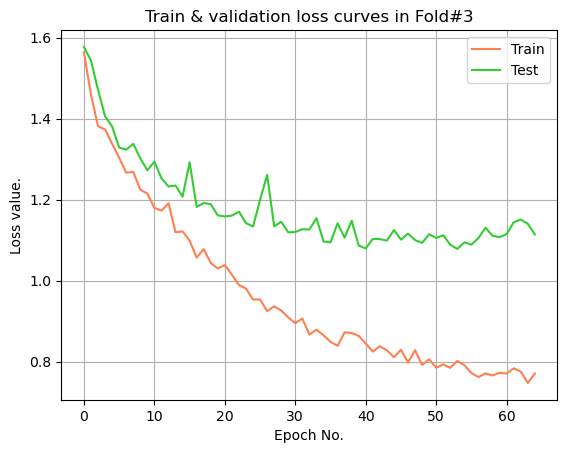

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5790744990035706 | Validation Loss : 1.592960931547922
Epoch : [20 / 100] || Train Loss : 0.9767941087110897 | Validation Loss : 1.229367153129386
Epoch : [40 / 100] || Train Loss : 0.8072278678865361 | Validation Loss : 1.1895768858080533
Epoch : [60 / 100] || Train Loss : 0.7434255810907311 | Validation Loss : 1.1998410710138292
early stopping
Training phase stopped in epoch#66.
fold 3 is done!!
best epoch is #31. validation loss : 1.1473729155171457


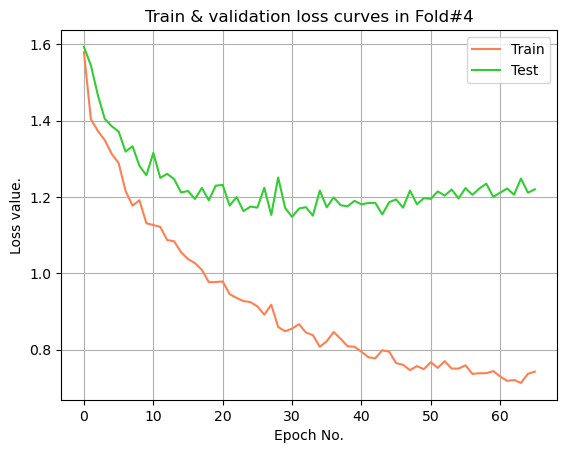

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6207416583422132 | Validation Loss : 1.2904891314818032
Epoch : [20 / 100] || Train Loss : 1.016696115782984 | Validation Loss : 1.120092751392767
Epoch : [40 / 100] || Train Loss : 0.8304029317726767 | Validation Loss : 1.117232230440456
Epoch : [60 / 100] || Train Loss : 0.769629232566757 | Validation Loss : 1.101658070506762
early stopping
Training phase stopped in epoch#63.
fold 4 is done!!
best epoch is #27. validation loss : 1.0723183358733976


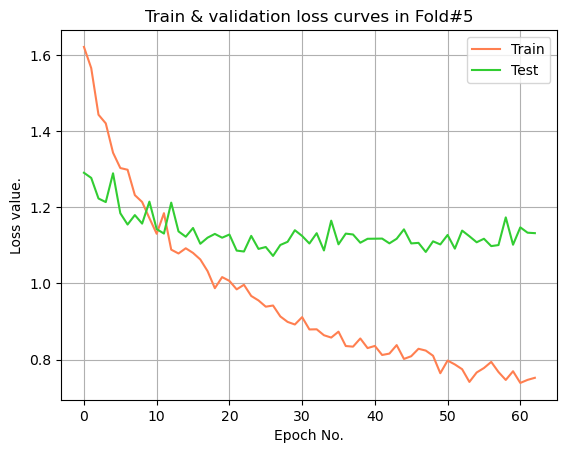

Saved fig.
===================== This is fold #4 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5362883438280266 | Validation Loss : 1.4344392728805542
Epoch : [20 / 100] || Train Loss : 1.0547962347267563 | Validation Loss : 1.1981414508819581
Epoch : [40 / 100] || Train Loss : 0.8377937397065396 | Validation Loss : 1.1405604338645936
Epoch : [60 / 100] || Train Loss : 0.7785689615395617 | Validation Loss : 1.1581158638000488
early stopping
Training phase stopped in epoch#63.
fold 0 is done!!
best epoch is #39. validation loss : 1.1292711329460143


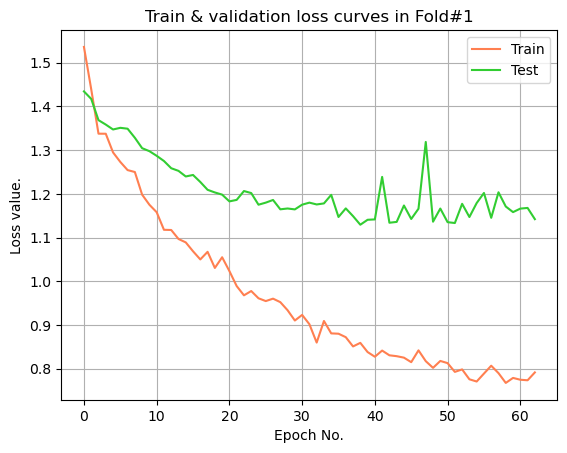

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5680057474480968 | Validation Loss : 1.2746359920501709
Epoch : [20 / 100] || Train Loss : 1.0078829321986909 | Validation Loss : 1.1128394603729248
Epoch : [40 / 100] || Train Loss : 0.8511595260842681 | Validation Loss : 1.1234168243408202
Epoch : [60 / 100] || Train Loss : 0.7930351322238688 | Validation Loss : 1.2050204753875733
Epoch : [80 / 100] || Train Loss : 0.740646007069979 | Validation Loss : 1.1833324003219605
early stopping
Training phase stopped in epoch#89.
fold 1 is done!!
best epoch is #16. validation loss : 1.1023373413085937


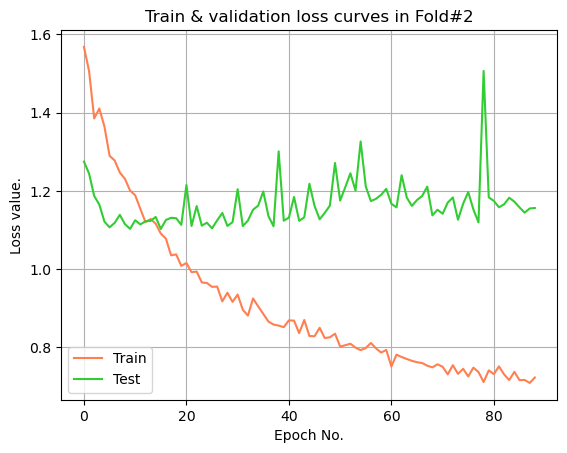

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4345675013716657 | Validation Loss : 1.6382672361393071
Epoch : [20 / 100] || Train Loss : 0.9964653071305507 | Validation Loss : 1.1669395826569753
Epoch : [40 / 100] || Train Loss : 0.8260663565537685 | Validation Loss : 1.110891565006582
Epoch : [60 / 100] || Train Loss : 0.7204316567657585 | Validation Loss : 1.1291290024417129
early stopping
Training phase stopped in epoch#64.
fold 2 is done!!
best epoch is #53. validation loss : 1.0871376236479486


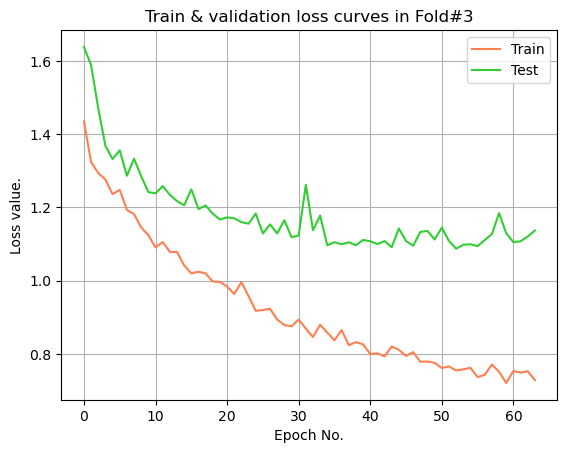

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6711709469482117 | Validation Loss : 1.4354428034930973
Epoch : [20 / 100] || Train Loss : 1.109190497183262 | Validation Loss : 1.1641131567595593
Epoch : [40 / 100] || Train Loss : 0.8682507832247511 | Validation Loss : 1.1577855540280366
Epoch : [60 / 100] || Train Loss : 0.8154776041071516 | Validation Loss : 1.25732234135345
early stopping
Training phase stopped in epoch#63.
fold 3 is done!!
best epoch is #51. validation loss : 1.135397185632332


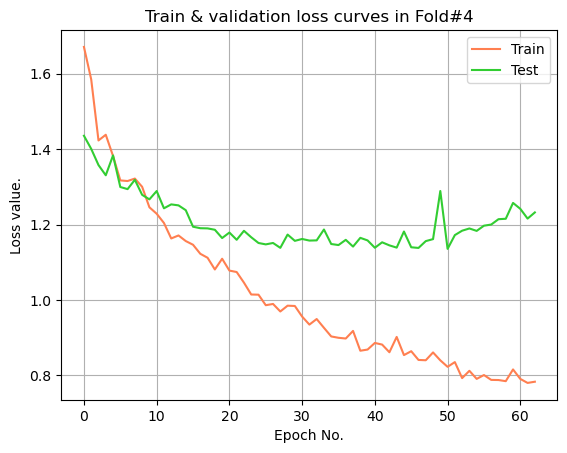

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5702607685461976 | Validation Loss : 1.3952167052120419
Epoch : [20 / 100] || Train Loss : 1.0140844942035532 | Validation Loss : 1.1034457072540744
Epoch : [40 / 100] || Train Loss : 0.8245308085491783 | Validation Loss : 1.1874790263535389
Epoch : [60 / 100] || Train Loss : 0.7504126991245681 | Validation Loss : 1.1613185837041193
early stopping
Training phase stopped in epoch#63.
fold 4 is done!!
best epoch is #20. validation loss : 1.1034457072540744


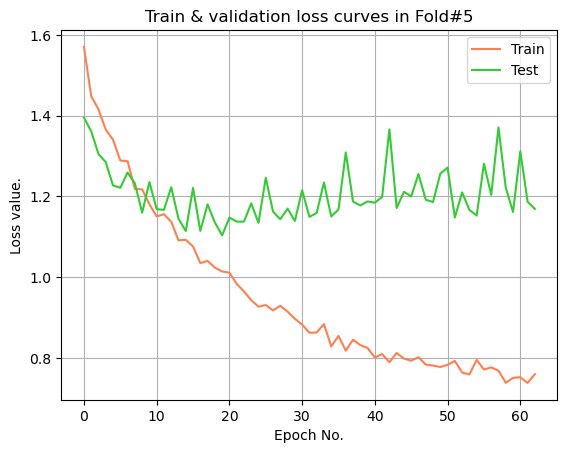

Saved fig.
===================== This is fold #5 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.607786970724874 | Validation Loss : 1.4414169120788574
Epoch : [20 / 100] || Train Loss : 0.9726085659850346 | Validation Loss : 1.1298112154006958
Epoch : [40 / 100] || Train Loss : 0.8133223058288938 | Validation Loss : 1.1269393920898438
Epoch : [60 / 100] || Train Loss : 0.7622719497572972 | Validation Loss : 1.203559503555298
early stopping
Training phase stopped in epoch#74.
fold 0 is done!!
best epoch is #30. validation loss : 1.1207093238830566


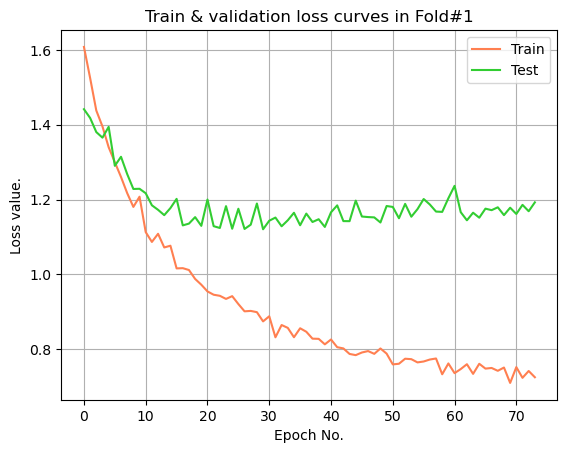

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5426644659700477 | Validation Loss : 1.3223151922225953
Epoch : [20 / 100] || Train Loss : 1.0078300348339295 | Validation Loss : 0.9927574920654297
Epoch : [40 / 100] || Train Loss : 0.782770570577911 | Validation Loss : 0.919863543510437
Epoch : [60 / 100] || Train Loss : 0.7308411282607573 | Validation Loss : 0.9778682160377502
early stopping
Training phase stopped in epoch#63.
fold 1 is done!!
best epoch is #40. validation loss : 0.919863543510437


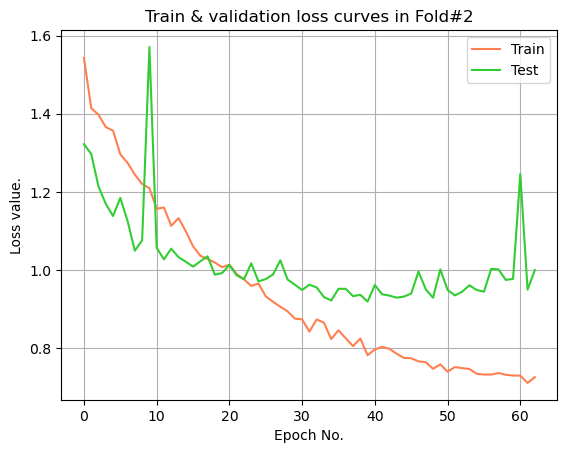

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5700066971002067 | Validation Loss : 1.5745867580624682
Epoch : [20 / 100] || Train Loss : 1.0086492156623899 | Validation Loss : 1.1954963434880703
Epoch : [40 / 100] || Train Loss : 0.815741052902432 | Validation Loss : 1.1254052456898904
Epoch : [60 / 100] || Train Loss : 0.7124830200558617 | Validation Loss : 1.1160131219643443
early stopping
Training phase stopped in epoch#68.
fold 2 is done!!
best epoch is #46. validation loss : 1.0724869792784877


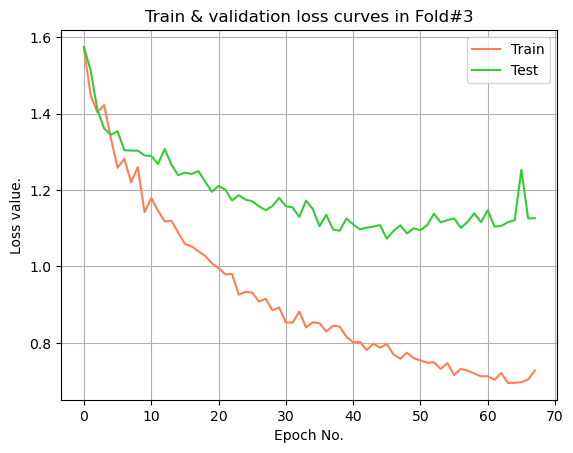

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.7129410436577666 | Validation Loss : 1.3246750651891508
Epoch : [20 / 100] || Train Loss : 1.0781946463094916 | Validation Loss : 1.084987470253029
Epoch : [40 / 100] || Train Loss : 0.880492149140303 | Validation Loss : 1.0963225772033385
Epoch : [60 / 100] || Train Loss : 0.7781477764734349 | Validation Loss : 1.10044644256333
Epoch : [80 / 100] || Train Loss : 0.7740515706533179 | Validation Loss : 1.1181265307431245
early stopping
Training phase stopped in epoch#84.
fold 3 is done!!
best epoch is #22. validation loss : 1.0542432743700305


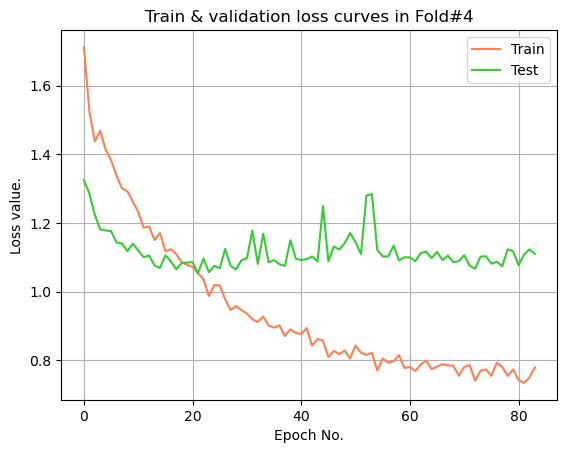

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.53536643987909 | Validation Loss : 1.542225709512605
Epoch : [20 / 100] || Train Loss : 1.0467863653536726 | Validation Loss : 1.1228288717605361
Epoch : [40 / 100] || Train Loss : 0.8111290244530317 | Validation Loss : 1.1331320270222036
Epoch : [60 / 100] || Train Loss : 0.7347504259052133 | Validation Loss : 1.2451447050775115
early stopping
Training phase stopped in epoch#69.
fold 4 is done!!
best epoch is #42. validation loss : 1.0969051374262901


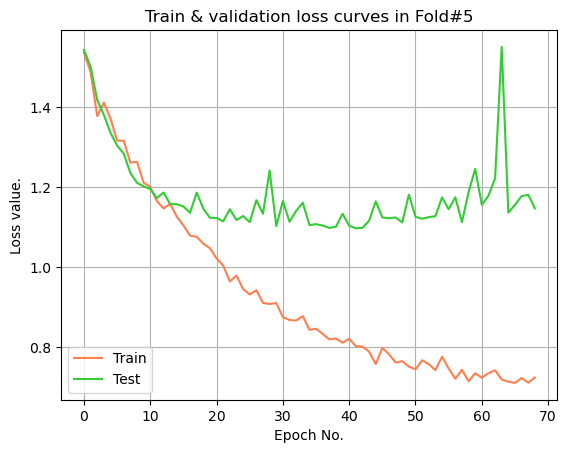

Saved fig.
best fold is 2. MAE = 9.444982436195414.
Mean MAE = 9.724271364145313 / std = 0.2811903308325461.


In [40]:
cross_val(dataset, param_dict = prm_set2, exp_name = "model2")

parameters : AttrDict({'n_epochs': 100, 'n_splits': 5, 'lr_init': '1e-3', 'weight_decay': '5e-3', 'patience': 10, 'ratio': 0.5, 'k': 9, 'lambda_p': 0.1, 'lambda_tpk': 0.1, 'batch_size': 32})
===================== This is fold #1 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.8153225297304854 | Validation Loss : 1.5213993835449218
Epoch : [20 / 100] || Train Loss : 1.0244017839431763 | Validation Loss : 1.2151629209518433
Epoch : [40 / 100] || Train Loss : 0.8294762498769329 | Validation Loss : 1.1349261093139649
Epoch : [60 / 100] || Train Loss : 0.7571618017838828 | Validation Loss : 1.0833517503738403
early stopping
Training phase stopped in epoch#67.
fold 0 is done!!
best epoch is #56. validation loss : 1.0777261877059936


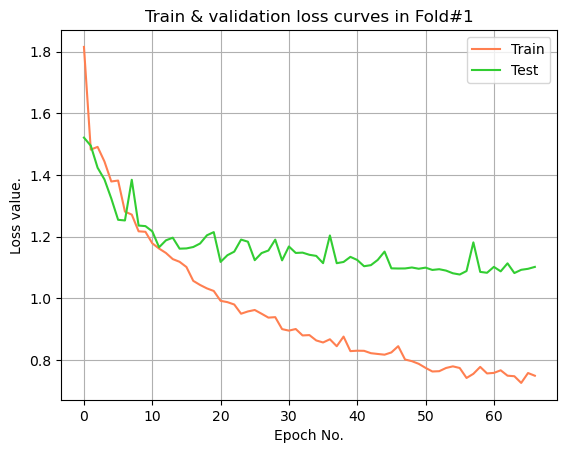

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6332709213421963 | Validation Loss : 1.5800966317929215
Epoch : [20 / 100] || Train Loss : 1.0306751114810575 | Validation Loss : 1.2054890543971228
Epoch : [40 / 100] || Train Loss : 0.8575722691106378 | Validation Loss : 1.2002951487823947
Epoch : [60 / 100] || Train Loss : 0.7978003069926685 | Validation Loss : 1.1579093957067135
early stopping
Training phase stopped in epoch#69.
fold 1 is done!!
best epoch is #58. validation loss : 1.1303385807641189


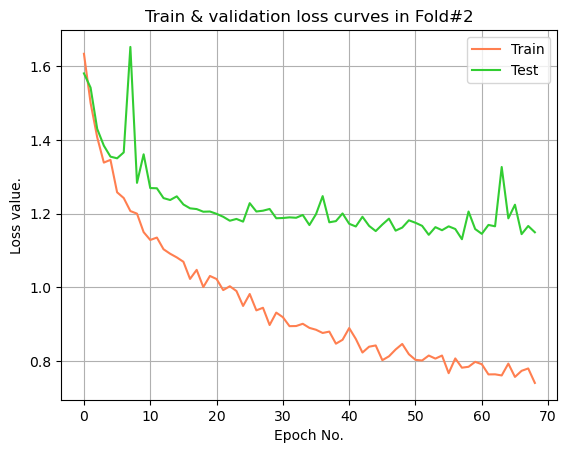

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.70328697027496 | Validation Loss : 1.2895111055230375
Epoch : [20 / 100] || Train Loss : 1.064348047919375 | Validation Loss : 0.9717503585408082
Epoch : [40 / 100] || Train Loss : 0.8514396173592045 | Validation Loss : 1.0365156917715792
Epoch : [60 / 100] || Train Loss : 0.7792537418781889 | Validation Loss : 1.0837860712453948
early stopping
Training phase stopped in epoch#73.
fold 2 is done!!
best epoch is #17. validation loss : 0.9698545390637077


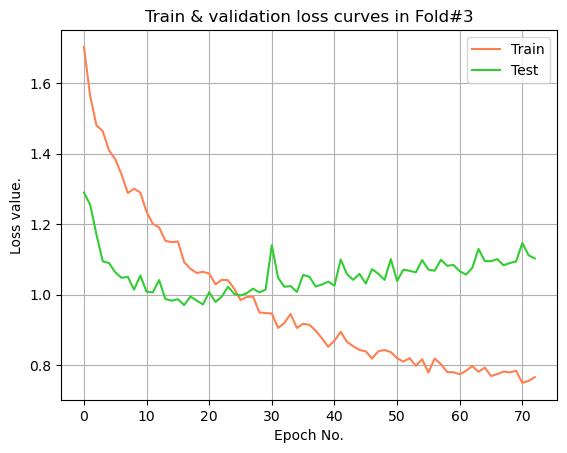

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5320157277838349 | Validation Loss : 1.5986187236392917
Epoch : [20 / 100] || Train Loss : 1.0342096509119798 | Validation Loss : 1.1462912080275953
Epoch : [40 / 100] || Train Loss : 0.8379081170561921 | Validation Loss : 1.2255655482186745
Epoch : [60 / 100] || Train Loss : 0.7696718867480231 | Validation Loss : 1.212054139106118
early stopping
Training phase stopped in epoch#66.
fold 3 is done!!
best epoch is #26. validation loss : 1.117307433530913


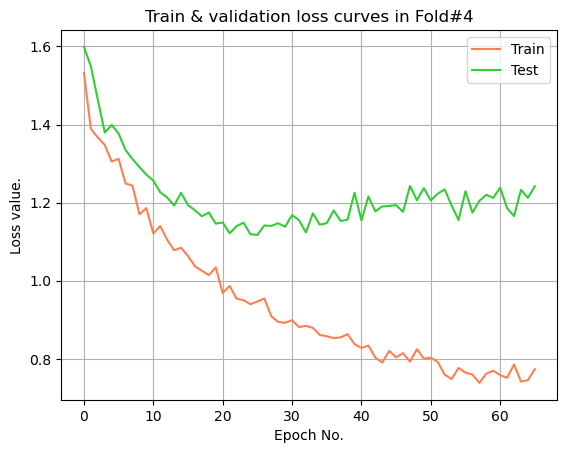

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.634395712142906 | Validation Loss : 1.2822056715212875
Epoch : [20 / 100] || Train Loss : 1.048522684026692 | Validation Loss : 1.0776108365562094
Epoch : [40 / 100] || Train Loss : 0.8396954627677219 | Validation Loss : 1.1288620658855342
Epoch : [60 / 100] || Train Loss : 0.7856095822871554 | Validation Loss : 1.1279724440981995
early stopping
Training phase stopped in epoch#71.
fold 4 is done!!
best epoch is #20. validation loss : 1.0776108365562094


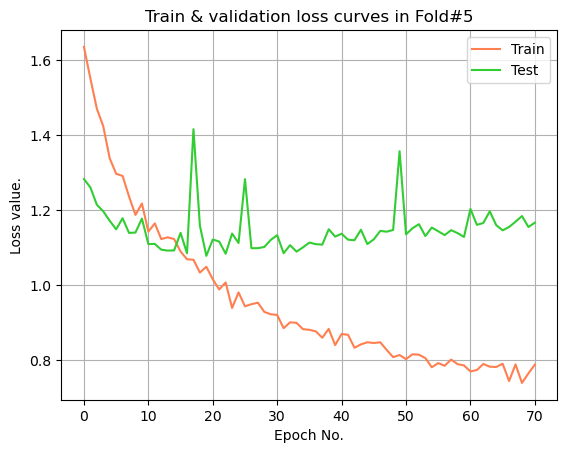

Saved fig.
===================== This is fold #2 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5256671914491928 | Validation Loss : 1.4654575681686401
Epoch : [20 / 100] || Train Loss : 1.0029626096057773 | Validation Loss : 1.1565043544769287
Epoch : [40 / 100] || Train Loss : 0.8329607875015086 | Validation Loss : 1.1124008703231811
Epoch : [60 / 100] || Train Loss : 0.7896047123103698 | Validation Loss : 1.234472632408142
early stopping
Training phase stopped in epoch#63.
fold 0 is done!!
best epoch is #30. validation loss : 1.1031682538986205


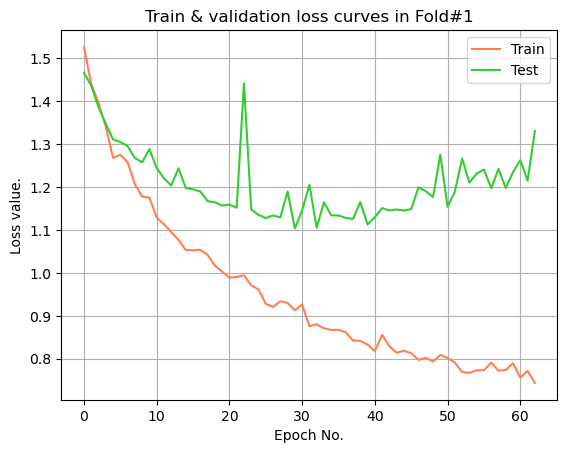

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.550554278653718 | Validation Loss : 1.3882734346389771
Epoch : [20 / 100] || Train Loss : 0.9902965240227234 | Validation Loss : 1.0833290100097657
Epoch : [40 / 100] || Train Loss : 0.7934910920512871 | Validation Loss : 1.04781090259552
Epoch : [60 / 100] || Train Loss : 0.7452601951218608 | Validation Loss : 1.156248745918274
early stopping
Training phase stopped in epoch#65.
fold 1 is done!!
best epoch is #27. validation loss : 1.0356726551055908


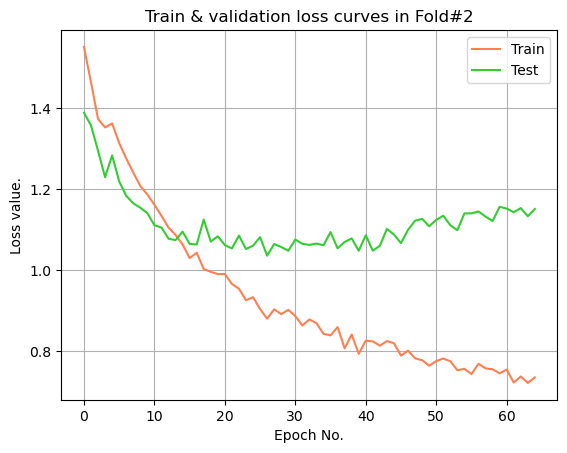

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6049978434292596 | Validation Loss : 1.2801596669096444
Epoch : [20 / 100] || Train Loss : 1.059191304041927 | Validation Loss : 1.0354453031741195
Epoch : [40 / 100] || Train Loss : 0.834673429790296 | Validation Loss : 1.0460871712646294
Epoch : [60 / 100] || Train Loss : 0.7655676695936007 | Validation Loss : 1.0571400717874269
early stopping
Training phase stopped in epoch#64.
fold 2 is done!!
best epoch is #22. validation loss : 1.0208077814111758


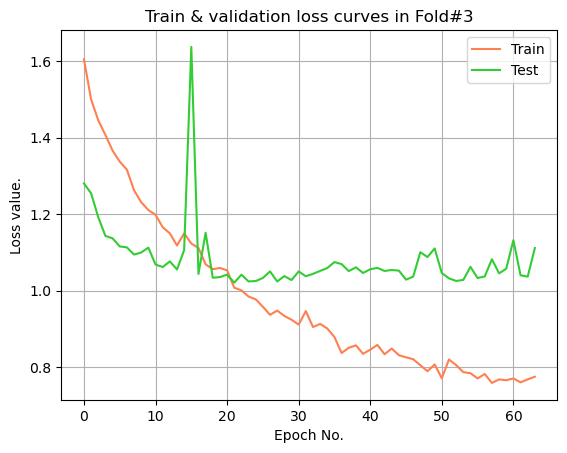

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.643114503463707 | Validation Loss : 1.6384151377270568
Epoch : [20 / 100] || Train Loss : 0.9956570403617725 | Validation Loss : 1.1712224812962901
Epoch : [40 / 100] || Train Loss : 0.8086201606836534 | Validation Loss : 1.1415308761836296
Epoch : [60 / 100] || Train Loss : 0.7364684976730729 | Validation Loss : 1.1419322110300687
early stopping
Training phase stopped in epoch#71.
fold 3 is done!!
best epoch is #25. validation loss : 1.1277508567925074


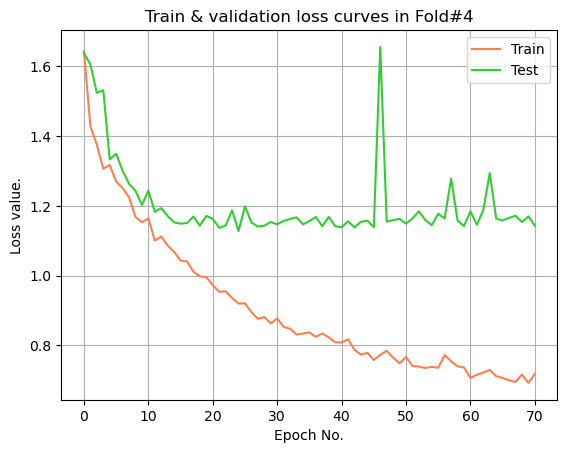

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5496571936404198 | Validation Loss : 1.2976078507888258
Epoch : [20 / 100] || Train Loss : 1.0174137949943542 | Validation Loss : 1.114802755902161
Epoch : [40 / 100] || Train Loss : 0.80524174073585 | Validation Loss : 1.1429869403791189
Epoch : [60 / 100] || Train Loss : 0.7368788756523514 | Validation Loss : 1.144867899429858
early stopping
Training phase stopped in epoch#64.
fold 4 is done!!
best epoch is #35. validation loss : 1.069273061488741


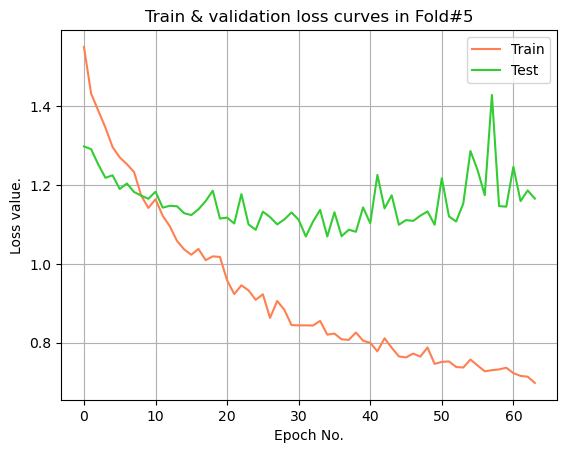

Saved fig.
===================== This is fold #3 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5227503006251872 | Validation Loss : 1.468358416557312
Epoch : [20 / 100] || Train Loss : 1.0185220407572115 | Validation Loss : 1.1065905451774598
Epoch : [40 / 100] || Train Loss : 0.8245400458836047 | Validation Loss : 1.132788109779358
Epoch : [60 / 100] || Train Loss : 0.7744939612923483 | Validation Loss : 1.1389783859252929
early stopping
Training phase stopped in epoch#63.
fold 0 is done!!
best epoch is #30. validation loss : 1.0629452276229858


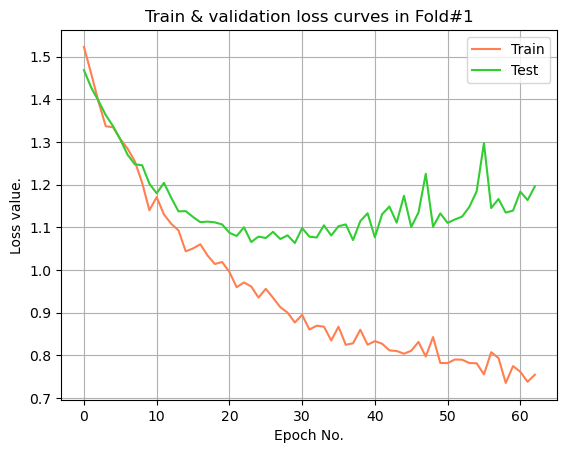

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.644628533156334 | Validation Loss : 1.2824265623092652
Epoch : [20 / 100] || Train Loss : 1.0347197809662094 | Validation Loss : 0.9930809736251831
Epoch : [40 / 100] || Train Loss : 0.8487376872090204 | Validation Loss : 1.2064496994018554
Epoch : [60 / 100] || Train Loss : 0.7904972874534922 | Validation Loss : 1.1852865314483643
early stopping
Training phase stopped in epoch#67.
fold 1 is done!!
best epoch is #16. validation loss : 0.969082145690918


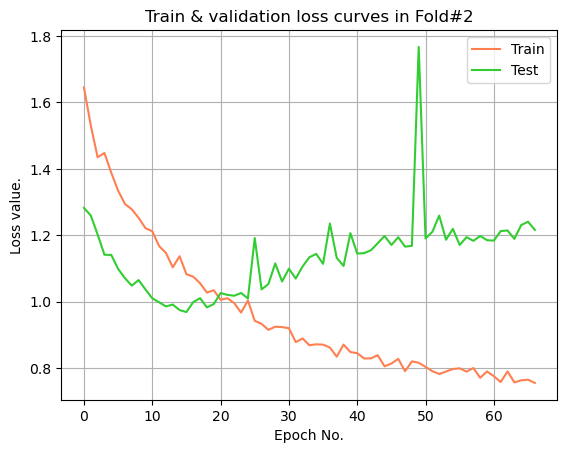

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5673885901171463 | Validation Loss : 1.5814886737109428
Epoch : [20 / 100] || Train Loss : 0.9939142107067251 | Validation Loss : 1.125595217374102
Epoch : [40 / 100] || Train Loss : 0.783321818313503 | Validation Loss : 1.1065618464695148
Epoch : [60 / 100] || Train Loss : 0.7216598969653136 | Validation Loss : 1.1525770581547339
early stopping
Training phase stopped in epoch#63.
fold 2 is done!!
best epoch is #34. validation loss : 1.104889818172359


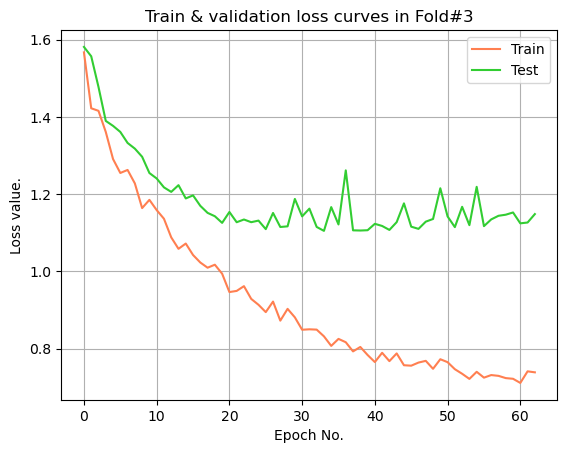

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5587350724633773 | Validation Loss : 1.6028489931743948
Epoch : [20 / 100] || Train Loss : 0.9733905087138776 | Validation Loss : 1.221345509416494
Epoch : [40 / 100] || Train Loss : 0.7920645717391395 | Validation Loss : 1.183871795484169
Epoch : [60 / 100] || Train Loss : 0.7115726795112878 | Validation Loss : 1.276577038082046
early stopping
Training phase stopped in epoch#63.
fold 3 is done!!
best epoch is #44. validation loss : 1.1579633969158383


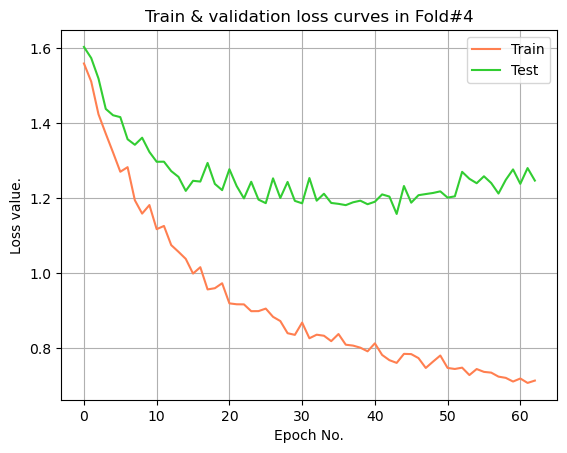

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5823710254559242 | Validation Loss : 1.3046180327333996
Epoch : [20 / 100] || Train Loss : 0.9904466865953049 | Validation Loss : 1.1110884172832547
Epoch : [40 / 100] || Train Loss : 0.8050754375027535 | Validation Loss : 1.1649594666370795
Epoch : [60 / 100] || Train Loss : 0.7605275568507966 | Validation Loss : 1.113036881140129
early stopping
Training phase stopped in epoch#71.
fold 4 is done!!
best epoch is #23. validation loss : 1.091660288710091


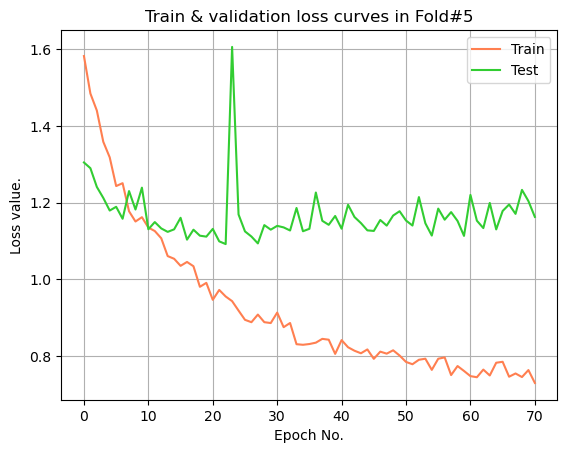

Saved fig.
===================== This is fold #4 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4831106641810092 | Validation Loss : 1.4351378345489503
Epoch : [20 / 100] || Train Loss : 1.0078900884953765 | Validation Loss : 1.1430047512054444
Epoch : [40 / 100] || Train Loss : 0.8254589497519557 | Validation Loss : 1.195263113975525
Epoch : [60 / 100] || Train Loss : 0.7871869919889395 | Validation Loss : 1.185010232925415
early stopping
Training phase stopped in epoch#79.
fold 0 is done!!
best epoch is #28. validation loss : 1.1258438444137573


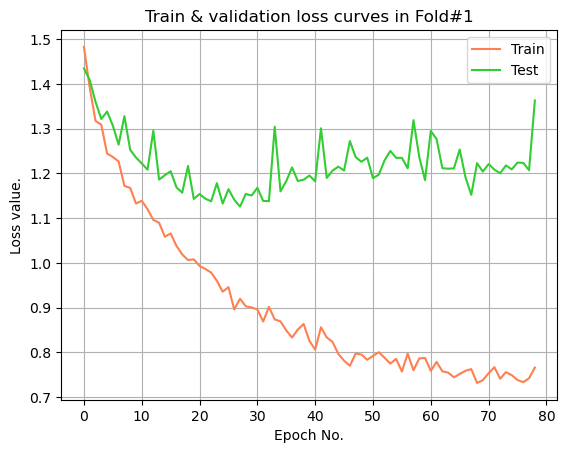

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5573132398586202 | Validation Loss : 1.2711323928833007
Epoch : [20 / 100] || Train Loss : 1.0235199594736997 | Validation Loss : 1.026869192123413
Epoch : [40 / 100] || Train Loss : 0.8062402497570368 | Validation Loss : 1.0314033460617065
Epoch : [60 / 100] || Train Loss : 0.7216812741651738 | Validation Loss : 1.1118011236190797
early stopping
Training phase stopped in epoch#65.
fold 1 is done!!
best epoch is #16. validation loss : 0.9862161207199097


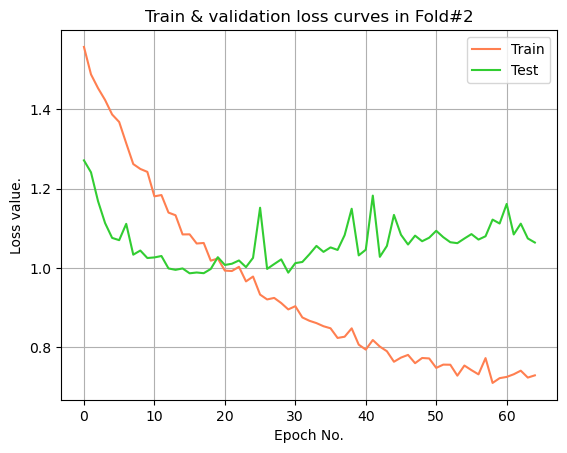

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4896896184237678 | Validation Loss : 1.6762910877639925
Epoch : [20 / 100] || Train Loss : 0.9481993629818871 | Validation Loss : 1.176867265198099
Epoch : [40 / 100] || Train Loss : 0.7973572556536299 | Validation Loss : 1.1269280407296953
Epoch : [60 / 100] || Train Loss : 0.7260810982314566 | Validation Loss : 1.1970311271485372
early stopping
Training phase stopped in epoch#74.
fold 2 is done!!
best epoch is #32. validation loss : 1.1199449486468904


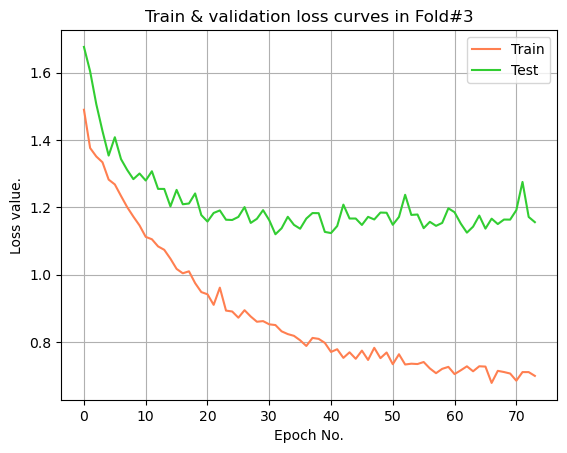

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5637178875151134 | Validation Loss : 1.4363005592595393
Epoch : [20 / 100] || Train Loss : 1.0176129066256951 | Validation Loss : 1.108993966675284
Epoch : [40 / 100] || Train Loss : 0.8490301379583832 | Validation Loss : 1.1213188159405885
Epoch : [60 / 100] || Train Loss : 0.802573195525578 | Validation Loss : 1.1443304665124596
early stopping
Training phase stopped in epoch#66.
fold 3 is done!!
best epoch is #37. validation loss : 1.0753967920739447


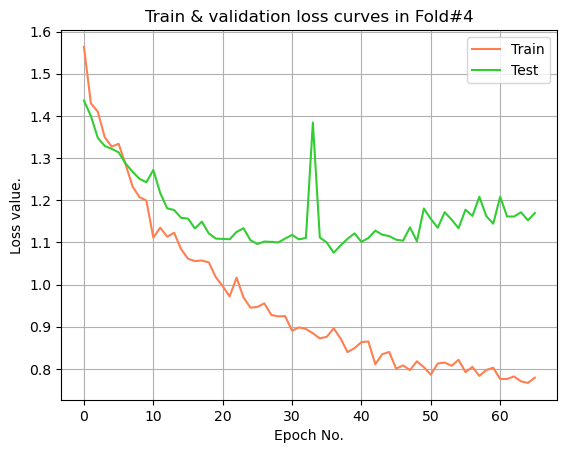

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5389442201843835 | Validation Loss : 1.3209578661463368
Epoch : [20 / 100] || Train Loss : 0.9928939172199794 | Validation Loss : 1.150055868541775
Epoch : [40 / 100] || Train Loss : 0.8070735704331171 | Validation Loss : 1.1563260549276917
Epoch : [60 / 100] || Train Loss : 0.7000742487441328 | Validation Loss : 1.2062955495700165
early stopping
Training phase stopped in epoch#63.
fold 4 is done!!
best epoch is #15. validation loss : 1.1196300875601457


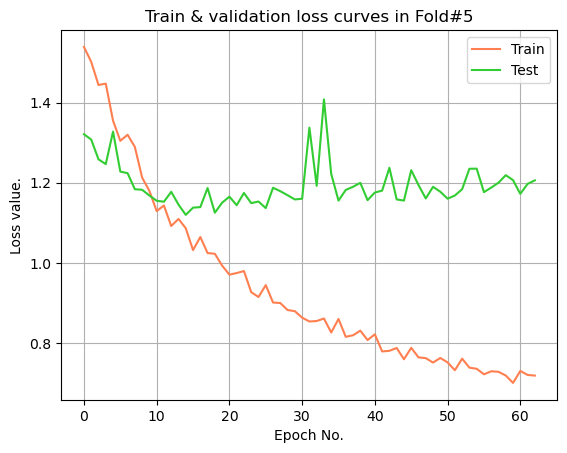

Saved fig.
===================== This is fold #5 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.520405384946797 | Validation Loss : 1.461492245197296
Epoch : [20 / 100] || Train Loss : 1.042449773629307 | Validation Loss : 1.14976233959198
Epoch : [40 / 100] || Train Loss : 0.8489910316287799 | Validation Loss : 1.0958741545677184
Epoch : [60 / 100] || Train Loss : 0.8062892369972717 | Validation Loss : 1.0583847332000733
early stopping
Training phase stopped in epoch#63.
fold 0 is done!!
best epoch is #52. validation loss : 1.0351555013656617


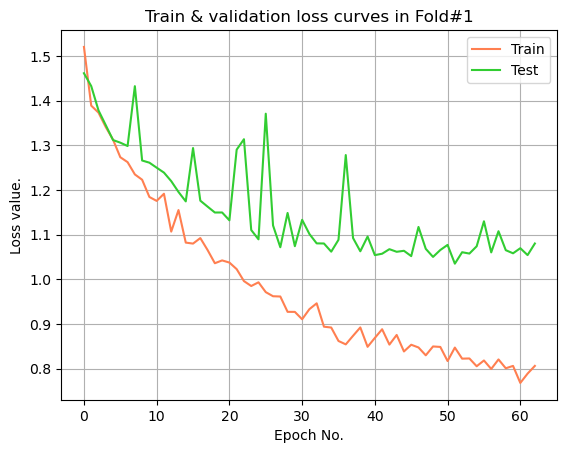

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.580302870856923 | Validation Loss : 1.3829607963562012
Epoch : [20 / 100] || Train Loss : 1.0099852230198858 | Validation Loss : 1.1625375747680664
Epoch : [40 / 100] || Train Loss : 0.8329969732794289 | Validation Loss : 1.1427701950073241
Epoch : [60 / 100] || Train Loss : 0.7703865670051 | Validation Loss : 1.0878799605369567
early stopping
Training phase stopped in epoch#67.
fold 1 is done!!
best epoch is #26. validation loss : 1.0060677003860474


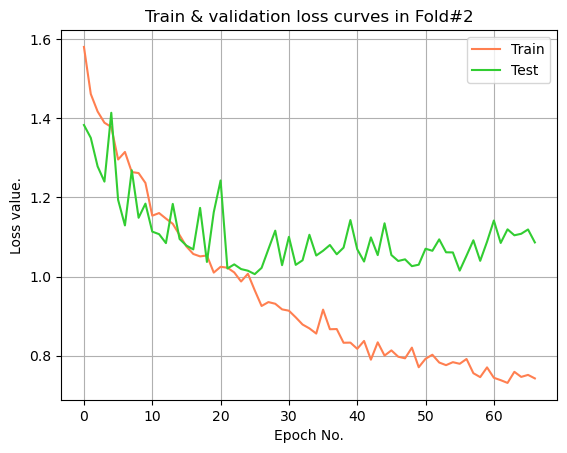

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5011967408627196 | Validation Loss : 1.6475040301605686
Epoch : [20 / 100] || Train Loss : 0.975401678778474 | Validation Loss : 1.243245946103005
Epoch : [40 / 100] || Train Loss : 0.7898316135382593 | Validation Loss : 1.178027614277212
Epoch : [60 / 100] || Train Loss : 0.724842972026433 | Validation Loss : 1.156372197309331
early stopping
Training phase stopped in epoch#72.
fold 2 is done!!
best epoch is #61. validation loss : 1.1438000052418542


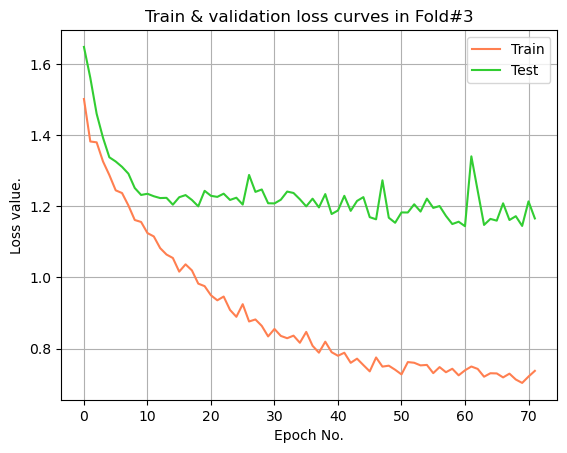

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.599226420983336 | Validation Loss : 1.336663095196288
Epoch : [20 / 100] || Train Loss : 1.0448956280423884 | Validation Loss : 1.0546702194453483
Epoch : [40 / 100] || Train Loss : 0.8574227947639045 | Validation Loss : 1.0856715371860333
Epoch : [60 / 100] || Train Loss : 0.7770586288662482 | Validation Loss : 1.0625376635460397
early stopping
Training phase stopped in epoch#63.
fold 3 is done!!
best epoch is #36. validation loss : 1.007551762326878


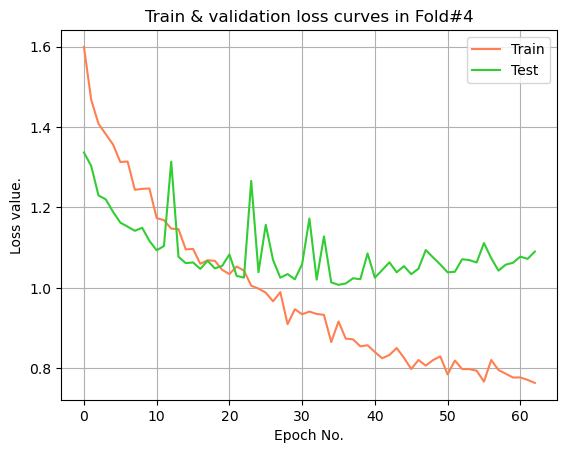

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6693014889432674 | Validation Loss : 1.5507768182898287
Epoch : [20 / 100] || Train Loss : 0.9792150602603616 | Validation Loss : 1.1607235975600967
Epoch : [40 / 100] || Train Loss : 0.8030391550601873 | Validation Loss : 1.1376155824517484
Epoch : [60 / 100] || Train Loss : 0.7115490209488642 | Validation Loss : 1.1358340193877867
early stopping
Training phase stopped in epoch#63.
fold 4 is done!!
best epoch is #38. validation loss : 1.1174475703407172


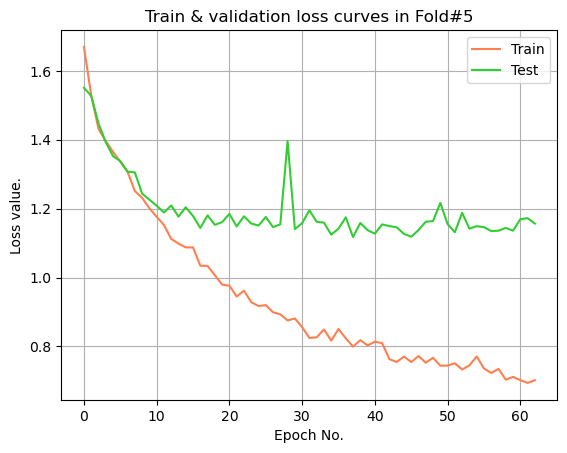

Saved fig.
best fold is 3. MAE = 9.361189675695531.
Mean MAE = 9.874379212399498 / std = 0.3113282340651442.


In [41]:
cross_val(dataset, param_dict = prm_set3, exp_name = "model3")

parameters : AttrDict({'n_epochs': 100, 'n_splits': 5, 'lr_init': '1e-3', 'weight_decay': '5e-3', 'patience': 10, 'ratio': 0.5, 'k': 10, 'lambda_p': 0.1, 'lambda_tpk': 0.1, 'batch_size': 32})
===================== This is fold #1 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5405836884100832 | Validation Loss : 1.4672889041900634
Epoch : [20 / 100] || Train Loss : 0.9974402470804339 | Validation Loss : 1.123340277671814
Epoch : [40 / 100] || Train Loss : 0.8100789360065556 | Validation Loss : 1.0961593437194823
Epoch : [60 / 100] || Train Loss : 0.7324429253237931 | Validation Loss : 1.1464205598831176
early stopping
Training phase stopped in epoch#65.
fold 0 is done!!
best epoch is #45. validation loss : 1.0697908544540404


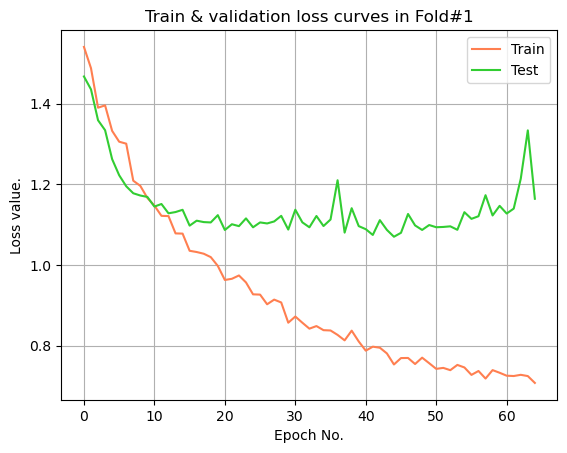

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5734859179971807 | Validation Loss : 1.5978042228737068
Epoch : [20 / 100] || Train Loss : 1.0191155980940596 | Validation Loss : 1.1395242064442468
Epoch : [40 / 100] || Train Loss : 0.8220194724751835 | Validation Loss : 1.1362343457475979
Epoch : [60 / 100] || Train Loss : 0.7605653954120621 | Validation Loss : 1.2180083918212048
early stopping
Training phase stopped in epoch#66.
fold 1 is done!!
best epoch is #32. validation loss : 1.1063754804170312


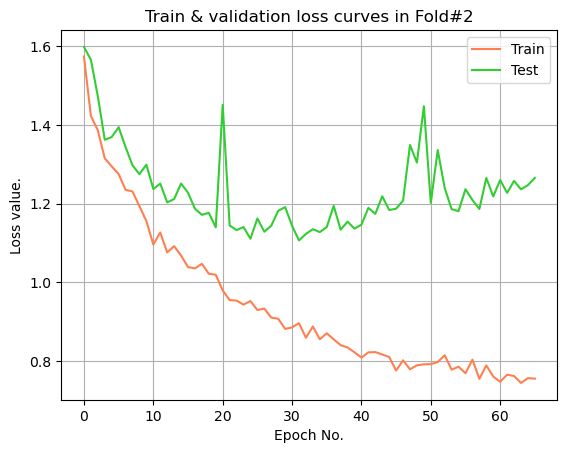

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6664052591419578 | Validation Loss : 1.2757846940701931
Epoch : [20 / 100] || Train Loss : 1.058187881856222 | Validation Loss : 0.9442342085454931
Epoch : [40 / 100] || Train Loss : 0.8761972616726961 | Validation Loss : 0.9854485464455495
Epoch : [60 / 100] || Train Loss : 0.8228923205749005 | Validation Loss : 1.0220094517846803
early stopping
Training phase stopped in epoch#67.
fold 2 is done!!
best epoch is #22. validation loss : 0.9298097850689336


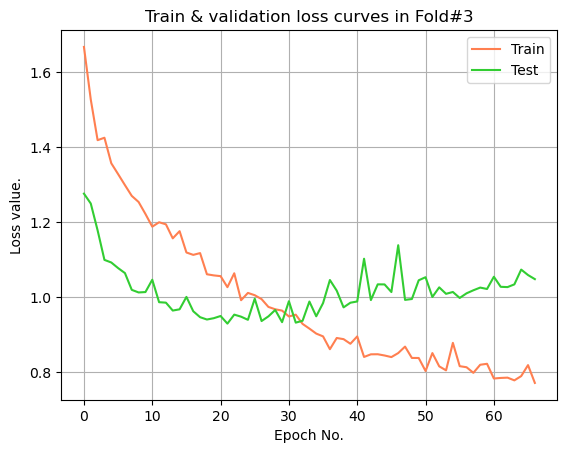

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.8104332712393634 | Validation Loss : 1.592106113781282
Epoch : [20 / 100] || Train Loss : 0.976961602979203 | Validation Loss : 1.199352567219854
Epoch : [40 / 100] || Train Loss : 0.7858668022801915 | Validation Loss : 1.1240677180601724
Epoch : [60 / 100] || Train Loss : 0.7325410918429625 | Validation Loss : 1.146832008457663
early stopping
Training phase stopped in epoch#68.
fold 3 is done!!
best epoch is #32. validation loss : 1.077730824599913


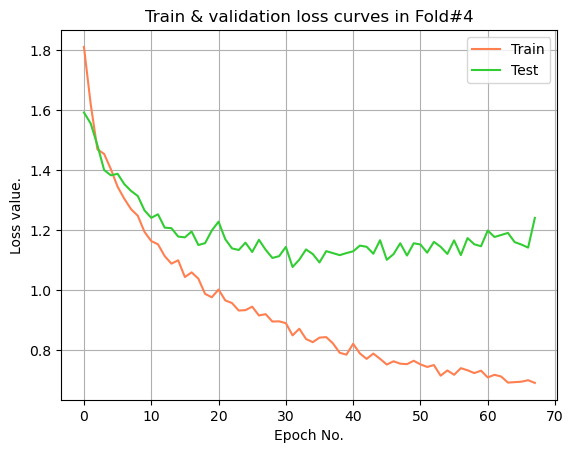

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.700592371421297 | Validation Loss : 1.3013801970074523
Epoch : [20 / 100] || Train Loss : 1.0509014376433312 | Validation Loss : 1.1404677216132082
Epoch : [40 / 100] || Train Loss : 0.8359851285235645 | Validation Loss : 1.1691133293075178
Epoch : [60 / 100] || Train Loss : 0.7569904137435491 | Validation Loss : 1.1664171734047895
early stopping
Training phase stopped in epoch#65.
fold 4 is done!!
best epoch is #21. validation loss : 1.109056539271944


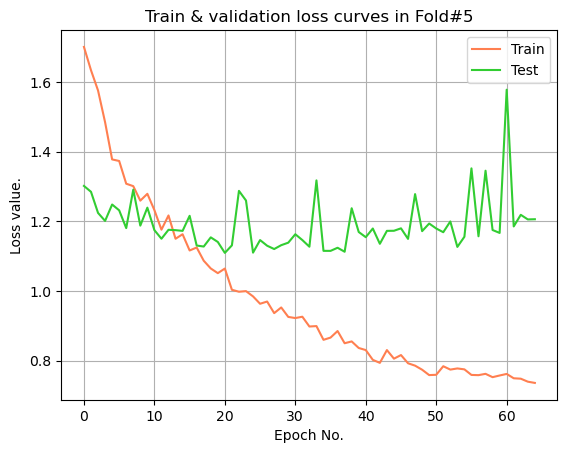

Saved fig.
===================== This is fold #2 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5511282992033917 | Validation Loss : 1.4681019401550293
Epoch : [20 / 100] || Train Loss : 0.982897113078511 | Validation Loss : 1.122543740272522
Epoch : [40 / 100] || Train Loss : 0.8235882997811962 | Validation Loss : 1.166309266090393
Epoch : [60 / 100] || Train Loss : 0.7599786795965551 | Validation Loss : 1.1291837644577027
early stopping
Training phase stopped in epoch#77.
fold 0 is done!!
best epoch is #66. validation loss : 1.0925711750984193


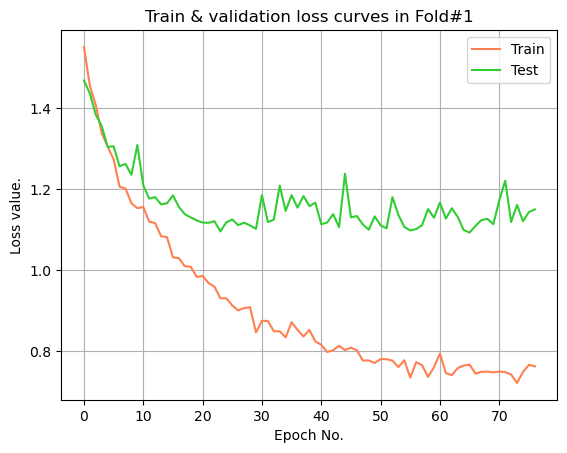

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6284693890862363 | Validation Loss : 1.4516671657562257
Epoch : [20 / 100] || Train Loss : 1.0264867692250979 | Validation Loss : 1.104355435371399
Epoch : [40 / 100] || Train Loss : 0.8282088457864979 | Validation Loss : 1.0859763622283936
Epoch : [60 / 100] || Train Loss : 0.7489043360522281 | Validation Loss : 1.1173397350311278
early stopping
Training phase stopped in epoch#69.
fold 1 is done!!
best epoch is #33. validation loss : 1.0748902654647827


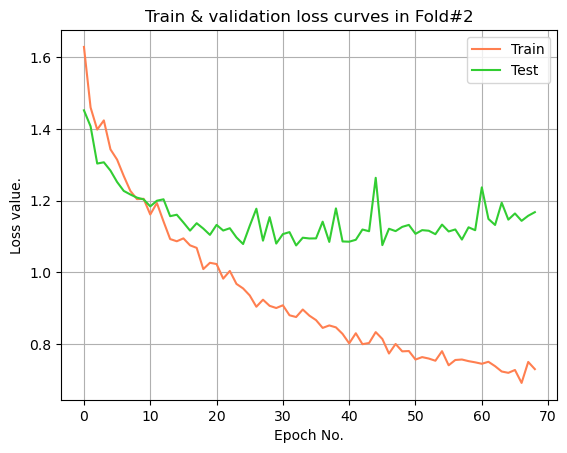

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4847751022281503 | Validation Loss : 1.2850993467335725
Epoch : [20 / 100] || Train Loss : 0.9360017585276362 | Validation Loss : 1.0767520076066406
Epoch : [40 / 100] || Train Loss : 0.7995681607334835 | Validation Loss : 1.0510792950888974
Epoch : [60 / 100] || Train Loss : 0.7572173107238043 | Validation Loss : 1.0800295199581127
early stopping
Training phase stopped in epoch#79.
fold 2 is done!!
best epoch is #14. validation loss : 0.9833210284386448


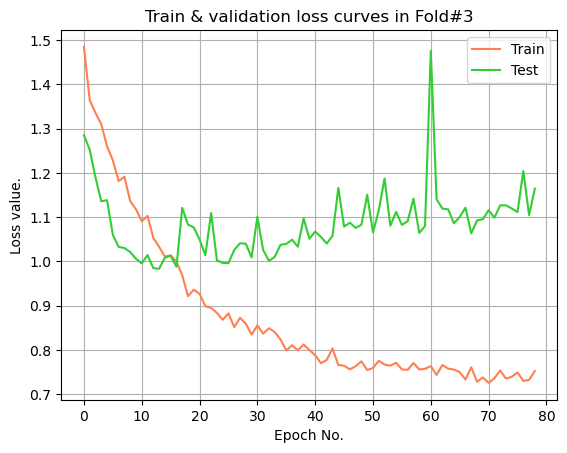

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.555663117788788 | Validation Loss : 1.6013918390226125
Epoch : [20 / 100] || Train Loss : 0.9607906801658764 | Validation Loss : 1.2287819918675638
Epoch : [40 / 100] || Train Loss : 0.7872045819920704 | Validation Loss : 1.2479215524903493
Epoch : [60 / 100] || Train Loss : 0.7229702070840917 | Validation Loss : 1.2646181265912464
early stopping
Training phase stopped in epoch#66.
fold 3 is done!!
best epoch is #27. validation loss : 1.1992724073592143


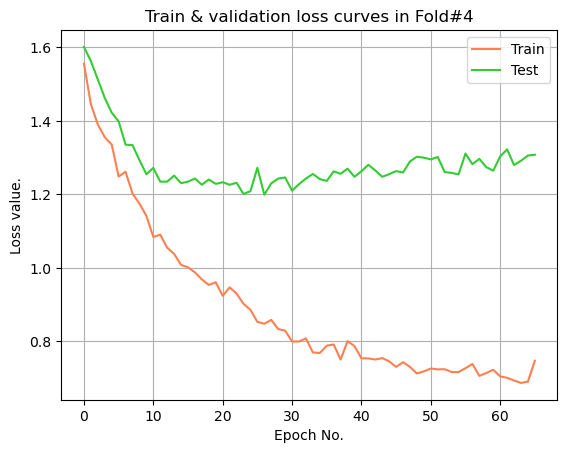

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6580080902367307 | Validation Loss : 1.320234484408968
Epoch : [20 / 100] || Train Loss : 0.9771343257492945 | Validation Loss : 1.039178600263356
Epoch : [40 / 100] || Train Loss : 0.7520231347633782 | Validation Loss : 1.1598543330053588
Epoch : [60 / 100] || Train Loss : 0.7256058493353669 | Validation Loss : 1.2248439830751274
early stopping
Training phase stopped in epoch#64.
fold 4 is done!!
best epoch is #24. validation loss : 1.0223361091997156


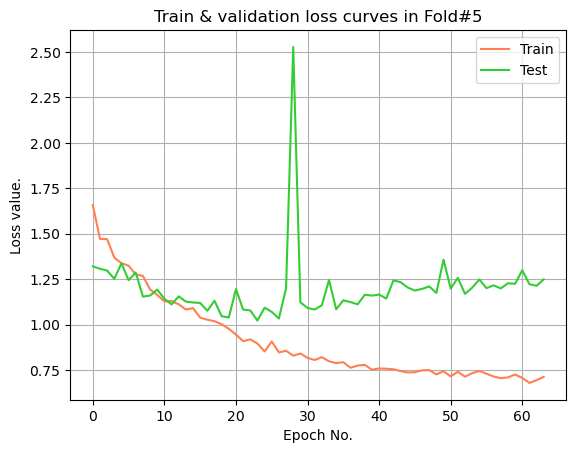

Saved fig.
===================== This is fold #3 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6335050775535134 | Validation Loss : 1.44520122051239
Epoch : [20 / 100] || Train Loss : 1.0137706440096368 | Validation Loss : 1.1333662939071656
Epoch : [40 / 100] || Train Loss : 0.8240791064134356 | Validation Loss : 1.1900843620300292
Epoch : [60 / 100] || Train Loss : 0.7837799445000317 | Validation Loss : 1.3864825201034545
early stopping
Training phase stopped in epoch#67.
fold 0 is done!!
best epoch is #31. validation loss : 1.0988337898254394


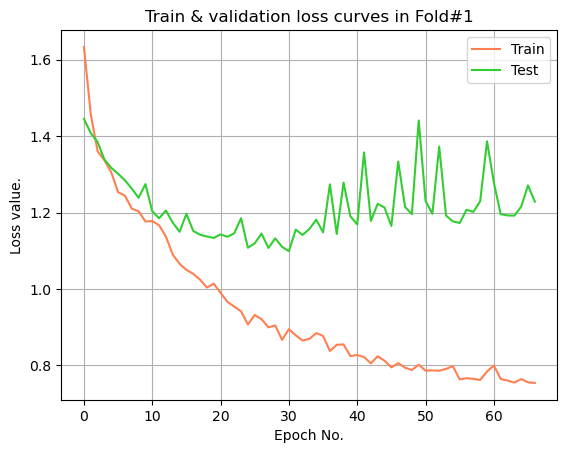

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5765778880795391 | Validation Loss : 1.2899605321884156
Epoch : [20 / 100] || Train Loss : 1.002636024015611 | Validation Loss : 1.0038497066497802
Epoch : [40 / 100] || Train Loss : 0.8057734668628783 | Validation Loss : 1.0081877660751344
Epoch : [60 / 100] || Train Loss : 0.766054768708898 | Validation Loss : 1.0054571294784547
early stopping
Training phase stopped in epoch#71.
fold 1 is done!!
best epoch is #20. validation loss : 1.0038497066497802


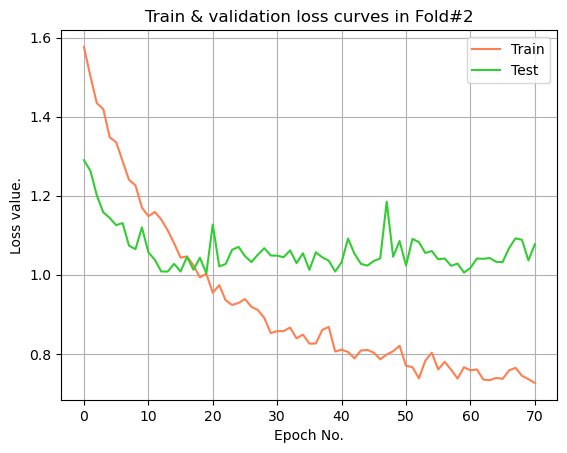

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5099811401582302 | Validation Loss : 1.5771989040638335
Epoch : [20 / 100] || Train Loss : 0.9717755006967033 | Validation Loss : 1.145702293769798
Epoch : [40 / 100] || Train Loss : 0.815079809430249 | Validation Loss : 1.1152899076591185
Epoch : [60 / 100] || Train Loss : 0.7792726102329436 | Validation Loss : 1.118944158506154
early stopping
Training phase stopped in epoch#67.
fold 2 is done!!
best epoch is #41. validation loss : 1.0882651128960614


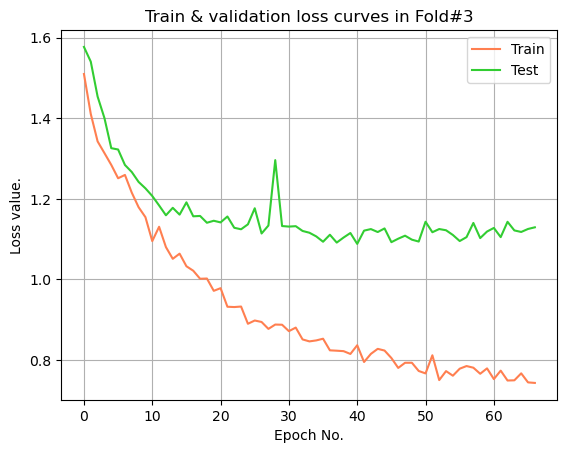

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.539064658016788 | Validation Loss : 1.5887509219011469
Epoch : [20 / 100] || Train Loss : 0.9552554131151739 | Validation Loss : 1.1535222464470407
Epoch : [40 / 100] || Train Loss : 0.759570338373495 | Validation Loss : 1.1618404669977314
Epoch : [60 / 100] || Train Loss : 0.7265760895602387 | Validation Loss : 1.1939660469491278
early stopping
Training phase stopped in epoch#67.
fold 3 is done!!
best epoch is #26. validation loss : 1.1214805943283004


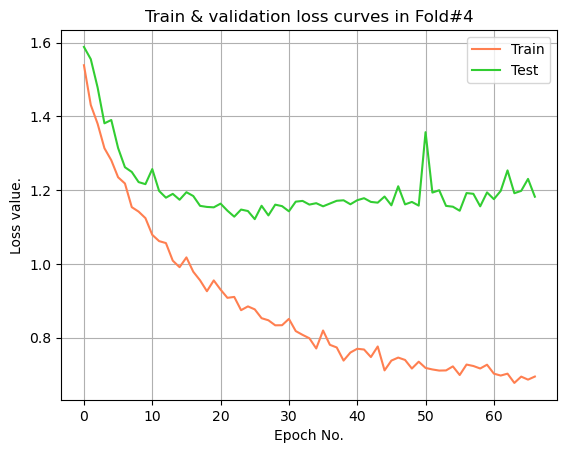

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6113814710076888 | Validation Loss : 1.2825198323283362
Epoch : [20 / 100] || Train Loss : 0.9633754602350986 | Validation Loss : 1.0709763495766338
Epoch : [40 / 100] || Train Loss : 0.7491572789082253 | Validation Loss : 1.0879291206149
Epoch : [60 / 100] || Train Loss : 0.7055387051780719 | Validation Loss : 1.069627334125078
early stopping
Training phase stopped in epoch#63.
fold 4 is done!!
best epoch is #29. validation loss : 1.0522448369606057


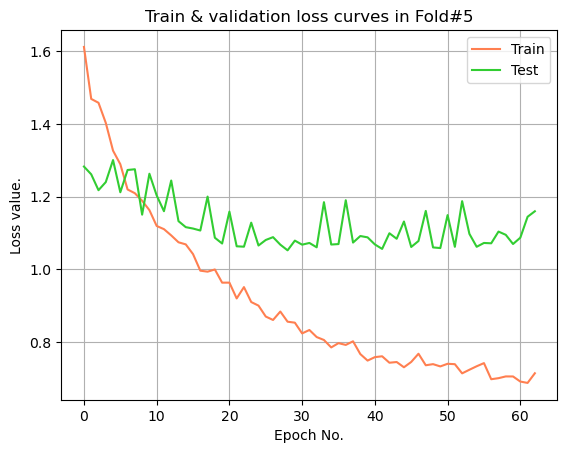

Saved fig.
===================== This is fold #4 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5474242102097686 | Validation Loss : 1.4526594161987305
Epoch : [20 / 100] || Train Loss : 0.9505775558903645 | Validation Loss : 1.1218784475326538
Epoch : [40 / 100] || Train Loss : 0.7702660852274302 | Validation Loss : 1.1427891302108764
Epoch : [60 / 100] || Train Loss : 0.7224622338150197 | Validation Loss : 1.1595694494247437
early stopping
Training phase stopped in epoch#68.
fold 0 is done!!
best epoch is #23. validation loss : 1.0766738915443421


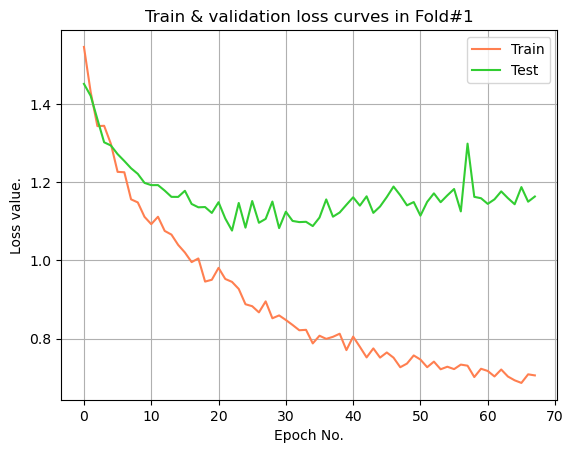

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6157321624803722 | Validation Loss : 1.2589362049102784
Epoch : [20 / 100] || Train Loss : 1.0442321068669203 | Validation Loss : 1.022577543258667
Epoch : [40 / 100] || Train Loss : 0.828558526194679 | Validation Loss : 1.0260508584976196
Epoch : [60 / 100] || Train Loss : 0.7448616113836224 | Validation Loss : 1.0554507303237914
Epoch : [80 / 100] || Train Loss : 0.7570495840297589 | Validation Loss : 1.1649825763702393
early stopping
Training phase stopped in epoch#80.
fold 1 is done!!
best epoch is #28. validation loss : 1.0123162174224853


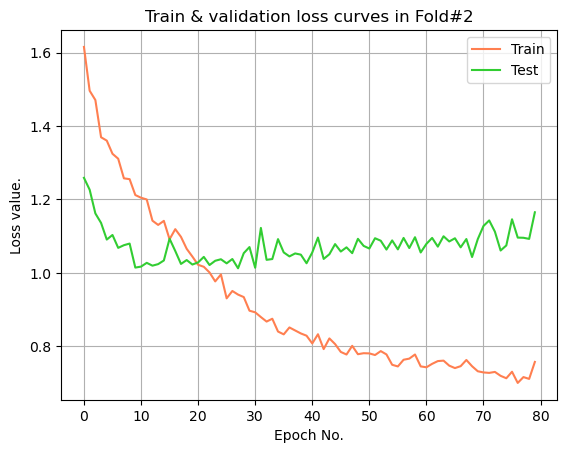

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4676277141523242 | Validation Loss : 1.5707155028779303
Epoch : [20 / 100] || Train Loss : 0.9165262517176176 | Validation Loss : 1.131983969678831
Epoch : [40 / 100] || Train Loss : 0.7543251583151949 | Validation Loss : 1.150920731937466
Epoch : [60 / 100] || Train Loss : 0.68691469105264 | Validation Loss : 1.143830643227352
early stopping
Training phase stopped in epoch#63.
fold 2 is done!!
best epoch is #49. validation loss : 1.0689707287591905


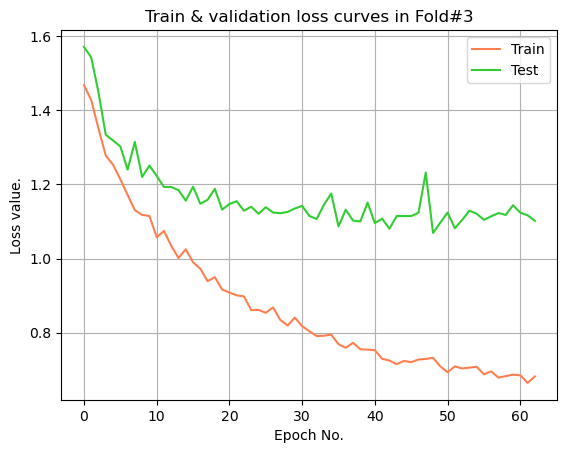

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6597875658432044 | Validation Loss : 1.4455124433316178
Epoch : [20 / 100] || Train Loss : 0.9962043432066017 | Validation Loss : 1.1688863961540874
Epoch : [40 / 100] || Train Loss : 0.8123827924704492 | Validation Loss : 1.1635388291660864
Epoch : [60 / 100] || Train Loss : 0.7460089932408249 | Validation Loss : 1.1752727367171092
early stopping
Training phase stopped in epoch#66.
fold 3 is done!!
best epoch is #18. validation loss : 1.1118721321000526


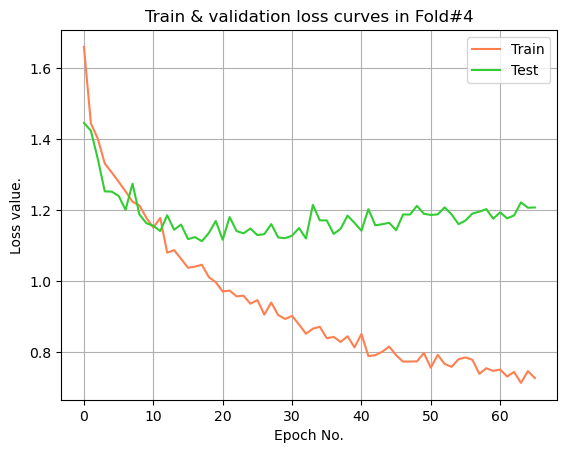

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.545599379037556 | Validation Loss : 1.2847526349014973
Epoch : [20 / 100] || Train Loss : 1.0103962313859982 | Validation Loss : 1.1842948647599723
Epoch : [40 / 100] || Train Loss : 0.7761099837477643 | Validation Loss : 1.3312120479554985
Epoch : [60 / 100] || Train Loss : 0.759031709722409 | Validation Loss : 1.2096608475824098
early stopping
Training phase stopped in epoch#65.
fold 4 is done!!
best epoch is #28. validation loss : 1.140614261579274


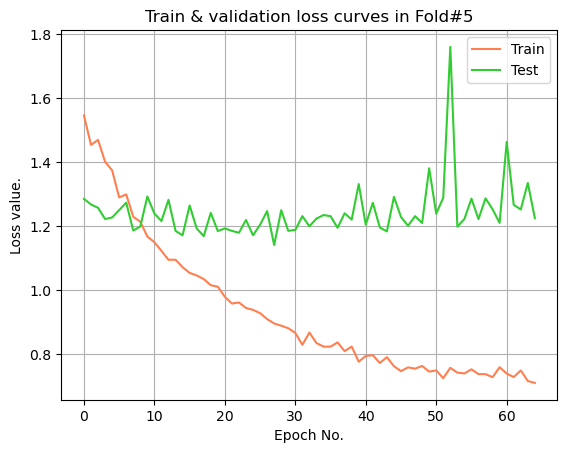

Saved fig.
===================== This is fold #5 / 5. =====================
-----------------------This is inner fold 1 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5625170222489417 | Validation Loss : 1.4328467273712158
Epoch : [20 / 100] || Train Loss : 0.9365342162932775 | Validation Loss : 1.10932058095932
Epoch : [40 / 100] || Train Loss : 0.770652374554159 | Validation Loss : 1.18572594165802
Epoch : [60 / 100] || Train Loss : 0.6834825585447859 | Validation Loss : 1.1327276563644408
early stopping
Training phase stopped in epoch#74.
fold 0 is done!!
best epoch is #36. validation loss : 1.0815717315673827


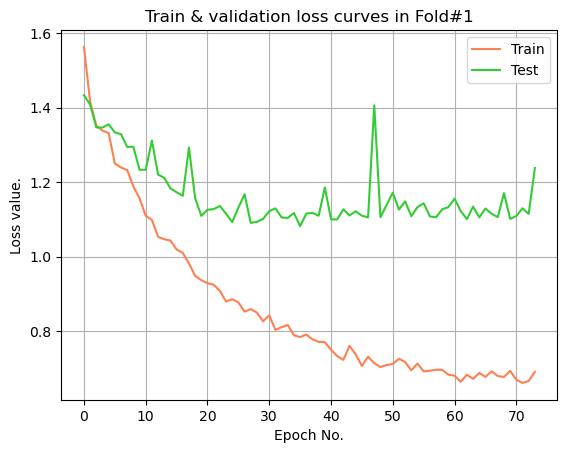

Saved fig.
-----------------------This is inner fold 2 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.6119977513998933 | Validation Loss : 1.2706388235092163
Epoch : [20 / 100] || Train Loss : 0.9684636690087121 | Validation Loss : 1.051336932182312
Epoch : [40 / 100] || Train Loss : 0.7684099368349073 | Validation Loss : 1.1195515632629394
Epoch : [60 / 100] || Train Loss : 0.6985412155519913 | Validation Loss : 1.0951927852630616
early stopping
Training phase stopped in epoch#73.
fold 1 is done!!
best epoch is #19. validation loss : 1.0195283460617066


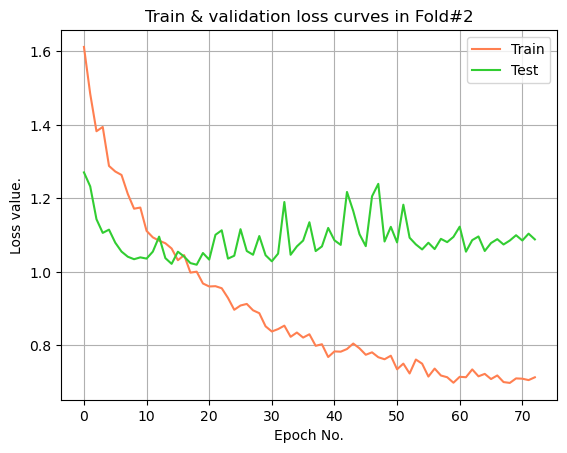

Saved fig.
-----------------------This is inner fold 3 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5166762690795095 | Validation Loss : 1.6393065686201929
Epoch : [20 / 100] || Train Loss : 0.9345168165096962 | Validation Loss : 1.1551445740551205
Epoch : [40 / 100] || Train Loss : 0.743602262403732 | Validation Loss : 1.1553973923975498
Epoch : [60 / 100] || Train Loss : 0.6683793894031591 | Validation Loss : 1.1193848728534563
early stopping
Training phase stopped in epoch#70.
fold 2 is done!!
best epoch is #59. validation loss : 1.0919332651037668


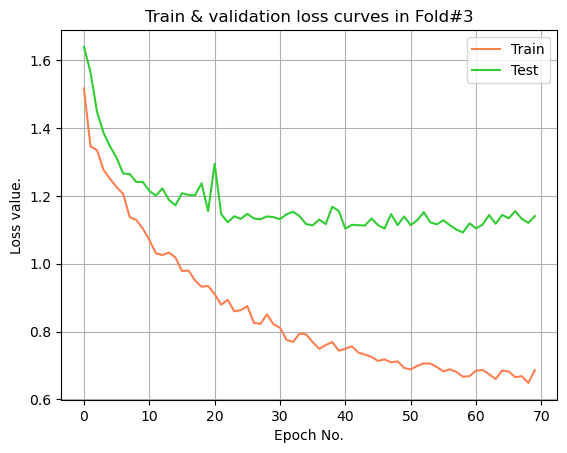

Saved fig.
-----------------------This is inner fold 4 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.5135130927078706 | Validation Loss : 1.3415959204860668
Epoch : [20 / 100] || Train Loss : 0.9776075510751634 | Validation Loss : 1.088105554257206
Epoch : [40 / 100] || Train Loss : 0.8213035881071162 | Validation Loss : 1.1202163324883236
Epoch : [60 / 100] || Train Loss : 0.7487545715537585 | Validation Loss : 1.1156697533837514
early stopping
Training phase stopped in epoch#68.
fold 3 is done!!
best epoch is #19. validation loss : 1.0689392617000408


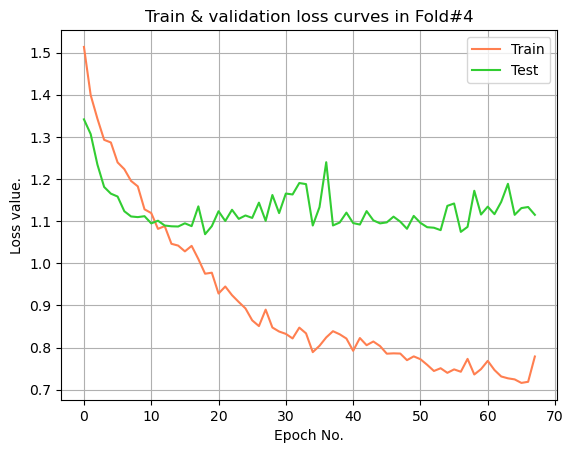

Saved fig.
-----------------------This is inner fold 5 / 5-----------------------
Epoch : [1 / 100] || Train Loss : 1.4827022779555548 | Validation Loss : 1.571012150702165
Epoch : [20 / 100] || Train Loss : 0.9956745076597783 | Validation Loss : 1.1554612789920826
Epoch : [40 / 100] || Train Loss : 0.8037417892525369 | Validation Loss : 1.1106388359213595
Epoch : [60 / 100] || Train Loss : 0.7663306776144749 | Validation Loss : 1.153603955728924
early stopping
Training phase stopped in epoch#66.
fold 4 is done!!
best epoch is #35. validation loss : 1.1081270752240664


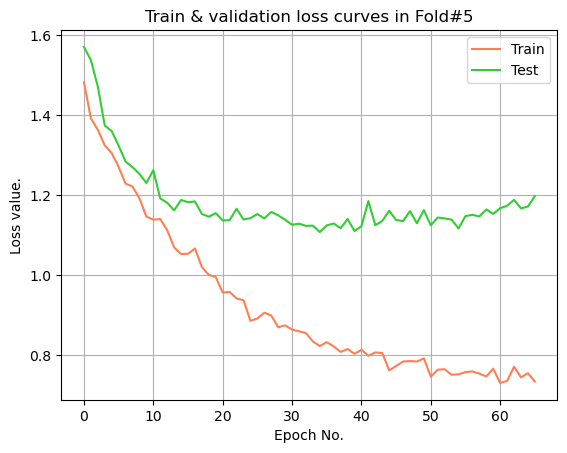

Saved fig.
best fold is 1. MAE = 9.44218913547873.
Mean MAE = 9.72466348167147 / std = 0.331550906930126.


In [42]:
cross_val(dataset, param_dict=prm_set4, exp_name = "model4")